# Дисперсионный анализ среднесуточных температур по метеостанциям РФ
*Данные получены из открытого источника Гидрометцентра*

## ИМПОРТ БИБЛИОТЕК
Импорт необходимых библиотек и обозначение пути до файлов с полученными данными.

- numpy -> для математических и логических операций с данными
- pandas -> для работы с табличными данными
- matplotlib -> для визуализации и построяния графиков
- os -> для чтения файлов
- re -> для работы с регулярными выражениями
- shapely -> для работы с точками (координаты метеостанций)
- geopandas -> для работы с геопространственными данными
- folium -> для построения карт

In [1]:
import os
import re
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functions import *
from shapely.geometry import Point, Polygon
import geopandas as gpd
import folium
import matplotlib.dates as mdates
import seaborn as sns

%matplotlib inline

mainDataPath = os.path.join('data', 'wr224635.txt')
# stationsNamesDataPath = os.path.join('data', 'statlist224635.txt')
fieldsDataPath = os.path.join('data', 'fld224635a0.txt')

**(УСТАРЕЛО)**
Далее надо сформировать из текстового файла с данными о кодах и местоположениях метеостанций data frame. 

In [2]:
# stations = []

# with open(stationsNamesDataPath, encoding="WINDOWS-1251") as f:
#     for line in f.readlines():
#         dataSt = re.split("\s+", line)[:-1]
#         if len(dataSt) > 3 and dataSt[-1] == "Россия":
#             m_name = " ".join(dataSt[1:-2]).strip()
#             stations.append([dataSt[0], m_name])
#         elif len(dataSt) <= 3 and dataSt[-1] == "Россия":
#             stations.append(dataSt[:-1])

# for dataSt in stations:
#     assert len(dataSt) == 2

# stationsDataFrame = pd.DataFrame(stations, columns=["Индекс ВМО", "Название станции"])
# stationsDataFrame = stationsDataFrame.set_index("Индекс ВМО")
# stationsDataFrame.head(10)

## ДАННЫЕ ПО МЕТЕОСТАНЦИЯМ

In [3]:
stations_df = pd.read_excel('coord_stations.xlsx')

In [4]:
stations_df.head(10)

,Индекс ВМО,Название станции,Широта,Долгота
0,20046,"Им.Э.Т.Кренкеля,ГМО",80.37,58.03
1,20069,Визе,79.30,76.59
2,20087,Голомянный,79.33,90.37
3,20107,Баренцбург,78.04,14.15
4,20289,Русский,77.10,96.26
5,20292,"Им.Е.К.Федорова,ГМО",77.43,104.18
6,20476,Стерлегова,75.4,88.8
7,20667,Им.М.В.Попова,73.20,70.03
8,20674,Диксон,73.30,80.24
9,20744,Малые Кармакулы,72.22,52.42


In [5]:
zones_FGR = [ Polygon([(64.951172, 69.534518), (66.09375, 67.542167), (59.765625, 64.358931), (57.65625, 56.897004), (62.050781, 49.95122), (50.273438, 37.996163), (13.974609, 50.958427), (5.625, 80.297927), (66.445313, 82.765373), (71.71875, 74.959392), (64.951172, 69.534518)]),
              Polygon([(66.269531, 67.542167), (59.765625, 64.396938), (57.568359, 56.897004), (62.050781, 49.894634), (87.714844, 47.813155), (91.494141, 54.572062), (87.363281, 63.391522), (87.890625, 65.98227), (82.96875, 71.773941), (82.96875, 80.928426), (66.445313, 82.765373), (71.630859, 75.00494), (64.775391, 69.565226), (66.269531, 67.542167)]),
              Polygon([(135.878906, 57.562995), (135.087891, 62.875188), (124.892578, 64.811557), (122.783203, 67.742759), (130.078125, 73.503461), (109.248047, 81.960148), (89.296875, 81.972431), (83.056641, 80.956099), (83.056641, 71.773941), (87.890625, 66.018018), (87.363281, 63.352129), (91.494141, 54.572062), (103.359375, 53.592505), (107.929688, 60.973107), (120.849609, 56.800878), (135.878906, 57.562995)]),
              Polygon([(91.494141, 54.572062), (103.359375, 53.592505), (108.105469, 60.973107), (120.673828, 56.897004), (121.992188, 53.383328), (118.037109, 45.706179), (87.802734, 47.754098), (91.494141, 54.572062)]),
              Polygon([(120.673828, 56.897004), (142.822266, 57.844751), (153.896484, 42.358544), (138.339844, 31.877558), (118.125, 45.644768), (121.904297, 53.383328), (120.673828, 56.897004)]),
              Polygon([(130.253906, 73.528399), (132.978516, 78.224513), (190.195313, 77.157163), (191.865234, 60.500525), (164.355469, 44.590467), (153.984375, 42.358544), (142.910156, 57.844751), (135.791016, 57.610107), (135, 62.875188), (124.804688, 64.811557), (122.695313, 67.709445), (130.253906, 73.528399)])
            ]
gdf_zones_FGR = gpd.GeoDataFrame(geometry=gpd.GeoSeries(zones_FGR), crs="EPSG:4326")

zones_Climate = [ Polygon([(33.75, 51.727028), (35.419922, 52.749594), (38.496094, 52.05249), (39.462891, 49.95122), (41.748047, 50.007739), (43.769531, 47.15984), (46.494141, 48.516604), (50.097656, 45.644768), (56.162109, 33.28462), (30.9375, 26.431228), (11.25, 41.771312), (33.75, 51.727028)]),
                  Polygon([(27.333984, 49.15297), (10.986328, 53.278353), (23.730469, 61.689872), (28.037109, 59.489726), (29.794922, 58.35563), (31.289063, 56.944974), (37.001953, 58.676938), (39.375, 55.72711), (41.835938, 55.128649), (52.03125, 51.508742), (50.185547, 45.644768), (46.582031, 48.458352), (43.769531, 47.219568), (41.660156, 49.95122), (39.462891, 50.064192), (38.496094, 52.05249), (35.332031, 52.749594), (33.837891, 51.727028), (27.333984, 49.15297)]),
                  Polygon([(23.730469, 61.731526), (29.003906, 64.623877), (39.199219, 60.630102), (47.988281, 60.973107), (49.658203, 59.220934), (52.03125, 60.413852), (59.501953, 61.773123), (66.181641, 58.539595), (70.224609, 59.844815), (75.234375, 58.631217), (77.255859, 60.844911), (84.902344, 61.100789), (88.505859, 59.130863), (105.292969, 59.977005), (112.324219, 58.995311), (115.751953, 60.413852), (122.695313, 56.511018), (131.396484, 54.213861), (146.513672, 53.278353), (142.207031, 34.161818), (140.361328, 46.619261), (139.306641, 48.283193), (137.285156, 48.166085), (136.845703, 46.920255), (129.990234, 46.920255), (112.851563, 35.245619), (56.25, 33.431441), (50.097656, 45.767523), (52.03125, 51.618017), (39.375, 55.72711), (37.001953, 58.722599), (31.289063, 56.992883), (29.882813, 58.309489), (23.730469, 61.731526)]),
                  Polygon([(23.554688, 72.448792), (44.736328, 69.9303), (49.130859, 66.018018), (52.470703, 66.998844), (61.875, 67.101656), (64.863281, 68.39918), (66.181641, 67.676085), (59.853516, 64.586185), (59.501953, 61.814664), (52.119141, 60.413852), (49.658203, 59.265881), (48.164063, 60.973107), (39.199219, 60.630102), (29.003906, 64.586185), (23.554688, 72.448792)]),
                  Polygon([(84.902344, 61.058285), (85.166016, 64.699105), (106.347656, 65.766727), (123.398438, 66.791909), (153.984375, 65.946472), (158.818359, 66.302205), (163.300781, 64.54844), (169.101563, 63.821288), (171.035156, 61.93895), (175.166016, 61.897578), (142.250977, 34.052659), (146.513672, 53.252069), ((131.352539, 54.213861)), (122.783203, 56.511018), (115.839844, 60.413852), (112.412109, 59.040555), (105.292969, 59.977005), (88.505859, 59.142135), (84.902344, 61.058285)]),
                  Polygon([(23.554688, 72.422268), (1.494141, 78.595299), (22.763672, 82.130427), (100.371094, 82.425629), (159.960938, 77.35107), (202.324219, 67.542167), (186.503906, 59.445075), (175.166016, 61.897578), (171.013184, 61.918271), (169.101563, 63.801894), (163.278809, 64.54844), (158.884277, 66.293373), (153.984375, 65.946472), (123.486328, 66.75725), (106.083984, 65.748683), (85.12207, 64.699105), (84.902344, 61.079544), (77.299805, 60.844911), (75.19043, 58.676938), (70.224609, 59.844815), (66.225586, 58.539595), (59.545898, 61.7939), (59.80957, 64.567319), (66.09375, 67.625954), (64.951172, 68.39918), (61.875, 67.08455), (52.558594, 66.998844), (49.174805, 66.00015), (44.736328, 69.915214), (23.554688, 72.422268)]),
                  Polygon([(129.902344, 46.860191), (136.845703, 46.920255), (137.373047, 48.224673), (139.306641, 48.341646), (140.361328, 46.619261), (142.207031, 34.161818), (112.851563, 35.38905), (129.902344, 46.860191)])
                ]
gdf_zones_Climate = gpd.GeoDataFrame(geometry=gpd.GeoSeries(zones_Climate), crs="EPSG:4326")


### Деление метеостанций по физико-географическим регионам

In [6]:
zones_FGR_df = []

for index, polygon in gdf_zones_FGR.iterrows():
    polygon_geom = polygon['geometry']
    points_in_polygon = pd.DataFrame(columns=stations_df.columns)
    for index, row in stations_df.iterrows():
        point = Point(row['Долгота'], row['Широта'])
        if polygon_geom.contains(point):
            points_in_polygon = pd.concat([points_in_polygon, pd.DataFrame(row).T])
            
    zones_FGR_df.append(points_in_polygon)        


In [7]:
m = folium.Map(location=[70.0, 100.0], zoom_start=3)
colors = ['purple', 'blue', 'yellow', 'pink', 'green', 'cyan' ]

for i, polygon in enumerate(zones_FGR):
    folium.GeoJson(data=polygon.__geo_interface__, style_function=lambda x, color=colors[i]: {'color': color}).add_to(m) 
    for j in range(0, len(zones_FGR_df[i])):
        popup=folium.Popup(f"{zones_FGR_df[i].iloc[j]['Название станции']} {zones_FGR_df[i].iloc[j]['Индекс ВМО']}")
        folium.CircleMarker(
            location=[zones_FGR_df[i].iloc[j]['Широта'], zones_FGR_df[i].iloc[j]['Долгота']],
            radius=4,
            color=colors[i],
            fill=True,
            fill_color=colors[i],
            popup=popup
        ).add_to(m)

m

### Деление метеостанций по климатическим зонам

In [8]:
zones_Climate_df = []

for index, polygon in gdf_zones_Climate.iterrows():
    polygon_geom = polygon['geometry']
    points_in_polygon = pd.DataFrame(columns=stations_df.columns)
    for index, row in stations_df.iterrows():
        point = Point(row['Долгота'], row['Широта'])
        if polygon_geom.contains(point):
            points_in_polygon = pd.concat([points_in_polygon, pd.DataFrame(row).T])
            
    zones_Climate_df.append(points_in_polygon) 

In [9]:
m = folium.Map(location=[70.0, 100.0], zoom_start=3)
colors = ['orange', 'green', 'red', 'blue', 'blue', 'yellow', 'green']

for i, polygon in enumerate(zones_Climate):
    folium.GeoJson(data=polygon.__geo_interface__, style_function=lambda x, color=colors[i]: {'color': color}).add_to(m) 
    for j in range(0, len(zones_Climate_df[i])):
        popup=folium.Popup(f"{zones_Climate_df[i].iloc[j]['Название станции']} {zones_Climate_df[i].iloc[j]['Индекс ВМО']}")
        folium.CircleMarker(
            location=[zones_Climate_df[i].iloc[j]['Широта'], zones_Climate_df[i].iloc[j]['Долгота']],
            radius=4,
            color=colors[i],
            fill=True,
            fill_color=colors[i],
            popup=popup
        ).add_to(m)

m

In [10]:
zones_Climate_df[3] = pd.concat([zones_Climate_df[3], zones_Climate_df[4]])
zones_Climate_df[4] = zones_Climate_df[5]
zones_Climate_df[5] = zones_Climate_df[6]
zones_Climate_df.pop()
zones_Climate_df[1] = pd.concat([zones_Climate_df[1], zones_Climate_df[5]])
zones_Climate_df.pop()

,Индекс ВМО,Название станции,Широта,Долгота
404,31829,Золотой,47.19,138.59
405,31845,Красный Яр,46.32,135.19
406,31873,Дальнереченск,45.52,133.44
407,31895,Мельничное,45.27,135.30
408,31909,Терней,45.00,136.36
409,31915,Пограничный,44.24,131.23
410,31931,Свиягино,44.8,133.1
411,31959,Рудная Пристань,44.22,135.51
412,31960,Владивосток,43.48,131.56
413,31961,Тимирязевский,43.53,131.58


## ДАННЫЕ ПО ТЕМПЕРАТУРАМ

In [11]:
header = []

with open(fieldsDataPath) as f:
    header = [" ".join(re.split("\s+", s)[4:]).strip() for s in f.readlines()]

assert len(header) == 9

mainDataFrame = pd.read_csv(mainDataPath, sep=";", header=None, names=header)
dateColumn = pd.to_datetime(mainDataFrame['Год'].astype(str) + '-' + mainDataFrame['Месяц'].astype(str) + '-' + mainDataFrame['День'].astype(str))

mainDataFrame.insert(1, "Дата", dateColumn)
mainDataFrame = mainDataFrame.set_index("Дата")
mainDataFrame = mainDataFrame.drop(["Год", "Месяц", "День"], axis=1)
mainDataFrame = mainDataFrame.drop(["Общий признак качества температур"], axis=1)
mainDataFrame = mainDataFrame.drop(["Количество осадков"], axis=1)

stations_df['Индекс ВМО'] = stations_df['Индекс ВМО'].astype('int64')
# mainDataFrame.index = pd.to_datetime(mainDataFrame.index)
mainDataFrame = mainDataFrame[mainDataFrame['Индекс ВМО'].isin(stations_df['Индекс ВМО'])]
temperatureCols = mainDataFrame.columns[1:4]
mainDataFrame.tail(10)



,Индекс ВМО,Минимальная температура воздуха,Средняя температура воздуха,Максимальная температура воздуха
Дата,,,,
2020-12-22,37663,-5.6,-2.6,0.2
2020-12-23,37663,-6.5,-2.2,2.6
2020-12-24,37663,-5.0,-2.5,-0.6
2020-12-25,37663,-7.6,-3.7,1.9
2020-12-26,37663,-4.3,-0.1,8.1
2020-12-27,37663,-0.5,5.2,16.0
2020-12-28,37663,-2.7,2.2,12.6
2020-12-29,37663,-5.2,-0.5,5.3
2020-12-30,37663,-5.2,0.7,13.4


In [12]:
temperatureCols = mainDataFrame.columns[1:4]
missingData(mainDataFrame, temperatureCols);

Пропущенные данные: 759736 из 11506133, что составляет 6.6%


In [13]:
void = "     "
mainDataFrame[temperatureCols] = mainDataFrame[temperatureCols].replace(void, None)
for col in temperatureCols:
    mainDataFrame[col] = mainDataFrame[col].astype(float)

In [14]:
missingData(mainDataFrame, temperatureCols);

Пропущенные данные: 0 из 11506133, что составляет 0.0%


## ONE-FACTOR ANOVA (ТРИДЦАТИЛЕТИЯ)

In [16]:
mainDataFrame = mainDataFrame.sort_index()

df_1961_1990 = mainDataFrame['1961-01-01':'1990-12-31']
df_1991_2020 = mainDataFrame['1991-01-01':'2020-12-31']

df_1961_1990_groups = df_1961_1990['Средняя температура воздуха'].groupby(df_1961_1990.index.month)
df_1991_2020_groups = df_1991_2020['Средняя температура воздуха'].groupby(df_1991_2020.index.month)

In [17]:
def range(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    return iqr

### Летние месяцы

In [19]:
df_1961_1990_summer = pd.concat([df_1961_1990_groups.get_group(6), df_1961_1990_groups.get_group(7), df_1961_1990_groups.get_group(8)])
df_1961_1990_summer = df_1961_1990_summer.resample("YE").mean()
group_1 = df_1961_1990_summer.values

df_1991_2020_summer = pd.concat([df_1991_2020_groups.get_group(6), df_1991_2020_groups.get_group(7), df_1991_2020_groups.get_group(8)])
df_1991_2020_summer = df_1991_2020_summer.resample("YE").mean()
group_2 = df_1991_2020_summer.values

groups = {'group_1': group_1, 'group_2': group_2 }

checkNormality(groups)
checkHomoscedasticity(groups)
res = oneFactorANOVA(groups)
if res[-1] < 0.05:
    print(f'Отвергаем гипотезу Н0, присутствует значимое различие между группами (p_value = {res[-1]:.12f})')
else:
    print(f'Принимаем гипотезу Н0, отсутсвует значимое различие между группами (p_value = {res[-1]:.12f})')

print(f'Среднее значение {np.mean(group_1):.3f}, {np.mean(group_2):.3f}')
print(f'Медиана {np.median(group_1):.3f}, {np.median(group_2):.3f}')
print(f'Размах значений {range(group_1):.3f}, {range(group_2):.3f}')
print(f'Среднеквадратичное отклонение {np.std(group_1):.3f}, {np.std(group_2):.3f}')

plt.figure(figsize=(8, 6))
ax = sns.boxplot(data=[group_1, group_2], palette="Set3")
ax.set_xticklabels(['1961-1990', '1991-2020'])
plt.title('Средние температуры в летние месяцы')
plt.ylabel('Средняя температура')
plt.xlabel('Период')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(df_1961_1990_summer.index, group_1, label='1961-1990')
plt.plot(df_1991_2020_summer.index, group_2, label='1991-2020')

x_values_1961_1990 = mdates.date2num(df_1961_1990_summer.index)
x_values_1991_2020 = mdates.date2num(df_1991_2020_summer.index)

z_1 = np.polyfit(x_values_1961_1990, group_1, 1)
p_1 = np.poly1d(z_1)
plt.plot(df_1961_1990_summer.index, p_1(x_values_1961_1990), color='purple', linestyle='--', label=f'Линия тренда 1961-1990: y={z_1[0]:.5f}x + {z_1[1]:.3f}')

z_2 = np.polyfit(x_values_1991_2020, group_2, 1)
p_2 = np.poly1d(z_2)
plt.plot(df_1991_2020_summer.index, p_2(x_values_1991_2020), color='orange', linestyle='--', label=f'Линия тренда 1991-2020: y={z_2[0]:.5f}x + {z_2[1]:.3f}')

plt.title('Динамика средней температуры в летние месяцы')
plt.xlabel('Год')
plt.ylabel('Средняя температура в летние месяцы')
plt.legend()
plt.show()

Образец из группы group_1 выглядит как нормальное распределение (не отвергаем H0) (p = 0.9012106995108079)
Образец из группы group_2 выглядит как нормальное распределение (не отвергаем H0) (p = 0.43898428035113424)


TypeError: ufunc 'bitwise_xor' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [25]:
df_1961_1990_summer = pd.DataFrame(df_1961_1990_summer)
df_1991_2020_summer = pd.DataFrame(df_1991_2020_summer)
df_1961_1990_summer.reset_index(drop=True, inplace=True)
df_1991_2020_summer.reset_index(drop=True, inplace=True)
groupsAll = pd.concat([df_1961_1990_summer, df_1991_2020_summer['Средняя температура воздуха']], axis=1)
groupsAll.columns = ['1961-1990', '1991-2020']

In [26]:
groupsAll.head()

,1961-1990,1991-2020
0,14.769502,15.465838
1,14.559956,14.050927
2,14.543682,14.718279
3,14.691895,14.863896
4,14.456454,15.406070


### Зимние месяцы

Образец из группы group_1 выглядит как нормальное распределение (не отвергаем H0) (p = 0.6823536722733872)
Образец из группы group_2 выглядит как нормальное распределение (не отвергаем H0) (p = 0.9183782780134898)
Дисперсии однородны (гомоскедастичность не отвергается) (1.1051676840551499 < 4.18296428905827)
Отвергаем гипотезу Н0, присутствует значимое различие между группами (p_value = 0.000120670080)
Среднее значение -17.555, -15.983
Медиана -17.711, -16.022
Размах значений 1.854, 1.784
Среднеквадратичное отклонение 1.527, 1.374


/var/folders/75/629qfrdj4fd2m28hk_zpnkrc0000gn/T/ipykernel_83419/57793675.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['1961-1990', '1991-2020'])


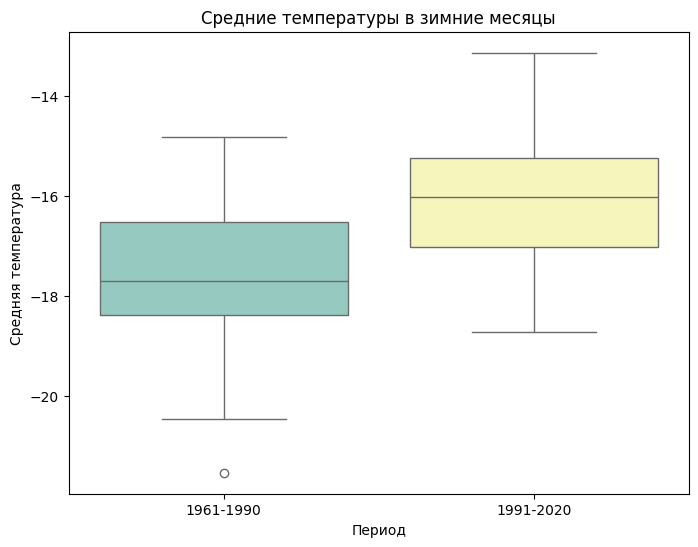

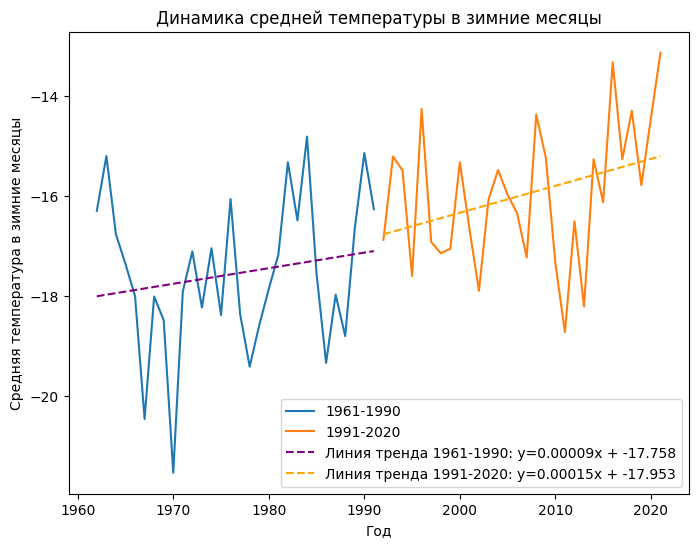

In [73]:
df_1961_1990_winter = pd.concat([df_1961_1990_groups.get_group(12), df_1961_1990_groups.get_group(1), df_1961_1990_groups.get_group(2)])
df_1961_1990_winter = df_1961_1990_winter.resample("YE").mean()
group_1 = df_1961_1990_winter.values

df_1991_2020_winter = pd.concat([df_1991_2020_groups.get_group(12), df_1991_2020_groups.get_group(1), df_1991_2020_groups.get_group(2)])
df_1991_2020_winter = df_1991_2020_winter.resample("YE").mean()
group_2 = df_1991_2020_winter.values

groups = {'group_1': group_1, 'group_2': group_2 }

checkNormality(groups)
checkHomoscedasticity(groups)
res = oneFactorANOVA(groups)
if res[-1] < 0.05:
    print(f'Отвергаем гипотезу Н0, присутствует значимое различие между группами (p_value = {res[-1]:.12f})')
else:
    print(f'Принимаем гипотезу Н0, отсутсвует значимое различие между группами (p_value = {res[-1]:.12f})')

print(f'Среднее значение {np.mean(group_1):.3f}, {np.mean(group_2):.3f}')
print(f'Медиана {np.median(group_1):.3f}, {np.median(group_2):.3f}')
print(f'Размах значений {range(group_1):.3f}, {range(group_2):.3f}')
print(f'Среднеквадратичное отклонение {np.std(group_1):.3f}, {np.std(group_2):.3f}')

plt.figure(figsize=(8, 6))
ax = sns.boxplot(data=[group_1, group_2], palette="Set3")
ax.set_xticklabels(['1961-1990', '1991-2020'])
plt.title('Средние температуры в зимние месяцы')
plt.ylabel('Средняя температура')
plt.xlabel('Период')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(df_1961_1990_winter.index, group_1, label='1961-1990')
plt.plot(df_1991_2020_winter.index, group_2, label='1991-2020')

x_values_1961_1990 = mdates.date2num(df_1961_1990_winter.index)
x_values_1991_2020 = mdates.date2num(df_1991_2020_winter.index)

z_1 = np.polyfit(x_values_1961_1990, group_1, 1)
p_1 = np.poly1d(z_1)
plt.plot(df_1961_1990_winter.index, p_1(x_values_1961_1990), color='purple', linestyle='--', label=f'Линия тренда 1961-1990: y={z_1[0]:.5f}x + {z_1[1]:.3f}')

z_2 = np.polyfit(x_values_1991_2020, group_2, 1)
p_2 = np.poly1d(z_2)
plt.plot(df_1991_2020_winter.index, p_2(x_values_1991_2020), color='orange', linestyle='--', label=f'Линия тренда 1991-2020: y={z_2[0]:.5f}x + {z_2[1]:.3f}')

plt.title('Динамика средней температуры в зимние месяцы')
plt.xlabel('Год')
plt.ylabel('Средняя температура в зимние месяцы')
plt.legend()
plt.show()

### Среднегодовая

Образец из группы group_1 выглядит как нормальное распределение (не отвергаем H0) (p = 0.5952789126413487)
Образец из группы group_2 выглядит как нормальное распределение (не отвергаем H0) (p = 0.3107748383147259)
Дисперсии однородны (гомоскедастичность не отвергается) (1.0668964424253653 < 4.18296428905827)
Отвергаем гипотезу Н0, присутствует значимое различие между группами (p_value = 0.000000003442)
Среднее значение -1.128, 0.135
Медиана -1.276, 0.066
Размах значений 0.911, 1.037
Среднеквадратичное отклонение 0.668, 0.714


/var/folders/75/629qfrdj4fd2m28hk_zpnkrc0000gn/T/ipykernel_83419/2411168497.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['1961-1990', '1991-2020'])


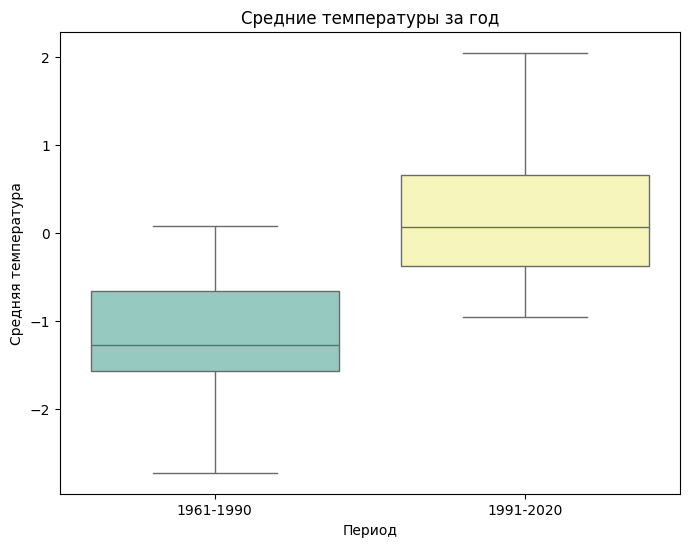

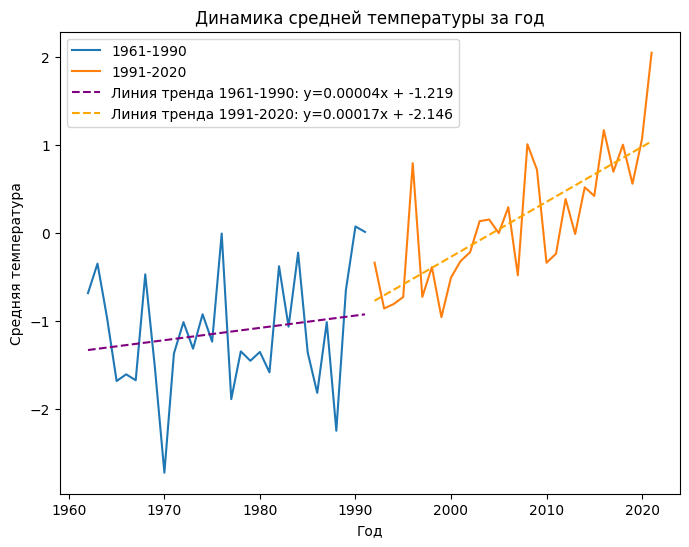

In [74]:
df_1961_1990_year = df_1961_1990['Средняя температура воздуха'].resample("YE").mean()
group_1 = df_1961_1990_year.values

df_1991_2020_year = df_1991_2020['Средняя температура воздуха'].resample("YE").mean()
group_2 = df_1991_2020_year.values

groups = {'group_1': group_1, 'group_2': group_2 }

checkNormality(groups)
checkHomoscedasticity(groups)
res = oneFactorANOVA(groups)
if res[-1] < 0.05:
    print(f'Отвергаем гипотезу Н0, присутствует значимое различие между группами (p_value = {res[-1]:.12f})')
else:
    print(f'Принимаем гипотезу Н0, отсутсвует значимое различие между группами (p_value = {res[-1]:.12f})')

print(f'Среднее значение {np.mean(group_1):.3f}, {np.mean(group_2):.3f}')
print(f'Медиана {np.median(group_1):.3f}, {np.median(group_2):.3f}')
print(f'Размах значений {range(group_1):.3f}, {range(group_2):.3f}')
print(f'Среднеквадратичное отклонение {np.std(group_1):.3f}, {np.std(group_2):.3f}')

plt.figure(figsize=(8, 6))
ax = sns.boxplot(data=[group_1, group_2], palette="Set3")
ax.set_xticklabels(['1961-1990', '1991-2020'])
plt.title('Средние температуры за год')
plt.ylabel('Средняя температура')
plt.xlabel('Период')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(df_1961_1990_year.index, group_1, label='1961-1990')
plt.plot(df_1991_2020_year.index, group_2, label='1991-2020')

x_values_1961_1990 = mdates.date2num(df_1961_1990_summer.index)
x_values_1991_2020 = mdates.date2num(df_1991_2020_summer.index)

z_1 = np.polyfit(x_values_1961_1990, group_1, 1)
p_1 = np.poly1d(z_1)
plt.plot(df_1961_1990_year.index, p_1(x_values_1961_1990), color='purple', linestyle='--', label=f'Линия тренда 1961-1990: y={z_1[0]:.5f}x + {z_1[1]:.3f}')

z_2 = np.polyfit(x_values_1991_2020, group_2, 1)
p_2 = np.poly1d(z_2)
plt.plot(df_1991_2020_year.index, p_2(x_values_1991_2020), color='orange', linestyle='--', label=f'Линия тренда 1991-2020: y={z_2[0]:.5f}x + {z_2[1]:.3f}')

plt.title('Динамика средней температуры за год')
plt.xlabel('Год')
plt.ylabel('Средняя температура')
plt.legend()
plt.show()

In [51]:
groups

{'group_1': array([-0.68447612, -0.3489255 , -0.96510079, -1.68351647, -1.60732495,
        -1.6745473 , -0.47098105, -1.52331207, -2.72569392, -1.37026643,
        -1.01380322, -1.31565826, -0.92477196, -1.23616343, -0.00636935,
        -1.88926488, -1.34633226, -1.45325178, -1.35279884, -1.58462287,
        -0.37849399, -1.06517102, -0.22401126, -1.35742642, -1.81862012,
        -1.01394785, -2.24855131, -0.64940153,  0.07364723,  0.01150378]),
 'group_2': array([-3.37452254e-01, -8.58999496e-01, -8.08426422e-01, -7.28270715e-01,
         7.93131490e-01, -7.27748906e-01, -3.88180869e-01, -9.57341940e-01,
        -5.08623097e-01, -3.20325671e-01, -2.19487781e-01,  1.33396374e-01,
         1.52395672e-01, -1.97331054e-03,  2.92556704e-01, -4.81371617e-01,
         1.00845958e+00,  7.18619852e-01, -3.39449403e-01, -2.35791932e-01,
         3.86016012e-01, -1.22800780e-02,  5.18710528e-01,  4.20488310e-01,
         1.16889674e+00,  6.95557371e-01,  1.00292843e+00,  5.58736695e-01,
      

## ONE-FACTOR ANOVA (ФГР ТРИДЦАТИЛЕТИЯ)

### Европейская часть России

In [15]:
df_1961_1990 = mainDataFrame['1961-01-01':'1990-12-31']
df_1991_2020 = mainDataFrame['1991-01-01':'2020-12-31']
df_1961_1990 = df_1961_1990[df_1961_1990['Индекс ВМО'].isin(zones_FGR_df[0]['Индекс ВМО'])]
df_1991_2020 = df_1991_2020[df_1991_2020['Индекс ВМО'].isin(zones_FGR_df[0]['Индекс ВМО'])]

KeyError: 'Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is not allowed.'

#### Среднегодовая

Образец из группы group_1 выглядит как нормальное распределение (не отвергаем H0) (p = 0.5952789126413487)
Образец из группы group_2 выглядит как нормальное распределение (не отвергаем H0) (p = 0.3107748383147259)
Отвергаем гипотезу Н0, присутствует значимое различие между группами (p_value = 3.4423796035909504e-09)


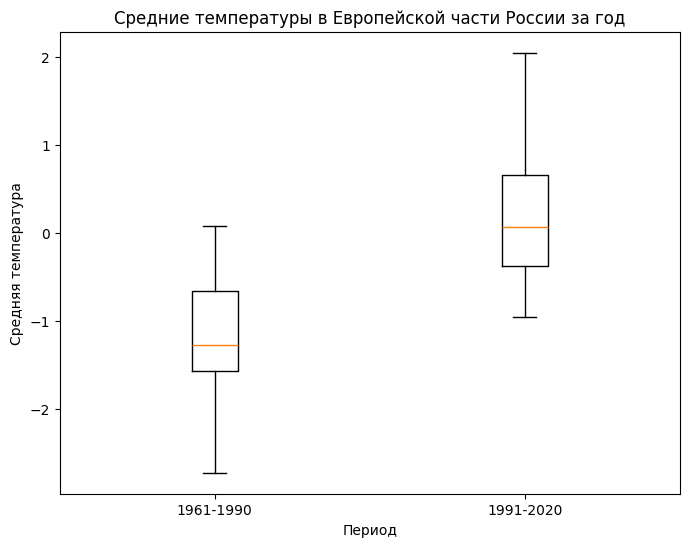

NameError: name 'df_1961_1990_winter' is not defined

<Figure size 800x600 with 0 Axes>

In [21]:
df_1961_1990_year = df_1961_1990['Средняя температура воздуха'].resample("YE").mean()
group_1 = df_1961_1990_year.values

df_1991_2020_year = df_1991_2020['Средняя температура воздуха'].resample("YE").mean()
group_2 = df_1991_2020_year.values

groups = {'group_1': group_1, 'group_2': group_2 }

checkNormality(groups)
# checkHomoscedasticity(groups)
res = oneFactorANOVA(groups)
if res < 0.05:
    print('Отвергаем гипотезу Н0, присутствует значимое различие между группами (p_value = {})'.format(res))
else:
    print('Принимаем гипотезу Н0, отсутсвует значимое различие между группами (p_value = {})'.format(res))

plt.figure(figsize=(8, 6))
plt.boxplot([group_1, group_2], labels=['1961-1990', '1991-2020'])
plt.title('Средние температуры в Европейской части России за год')
plt.ylabel('Средняя температура')
plt.xlabel('Период')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(df_1961_1990_winter.index, group_1, label='1961-1990')
plt.plot(df_1991_2020_winter.index, group_2, label='1991-2020')

x_values_1961_1990 = mdates.date2num(df_1961_1990_winter.index)
x_values_1991_2020 = mdates.date2num(df_1991_2020_winter.index)

z_1 = np.polyfit(x_values_1961_1990, group_1, 1)
p_1 = np.poly1d(z_1)
plt.plot(df_1961_1990_winter.index, p_1(x_values_1961_1990), color='purple', linestyle='--', label=f'Линия тренда 1961-1990: y={z_1[0]:.5f}x + {z_1[1]:.3f}')

z_2 = np.polyfit(x_values_1991_2020, group_2, 1)
p_2 = np.poly1d(z_2)
plt.plot(df_1991_2020_winter.index, p_2(x_values_1991_2020), color='orange', linestyle='--', label=f'Линия тренда 1991-2020: y={z_2[0]:.5f}x + {z_2[1]:.3f}')

plt.title('Динамика средней температуры в Европейской части России за год')
plt.xlabel('Год')
plt.ylabel('Средняя температура в зимние месяцы')
plt.legend()
plt.show()



### Восточная Сибирь

Образец из группы group_1 выглядит как нормальное распределение (не отвергаем H0) (p = 0.8050655893568816)
Образец из группы group_2 выглядит как нормальное распределение (не отвергаем H0) (p = 0.41234655314898777)
Среднее значение 3.981, 5.030
Медиана 4.009, 5.121
Размах значений 1.404, 0.834
Среднеквадратичное отклонение 0.858, 0.722
Отвергаем гипотезу Н0, присутствует значимое различие между группами (p_value = 0.000004918129)


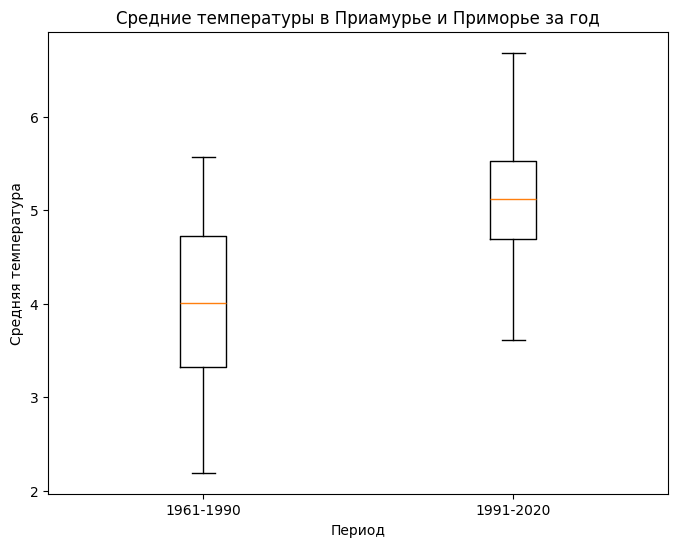

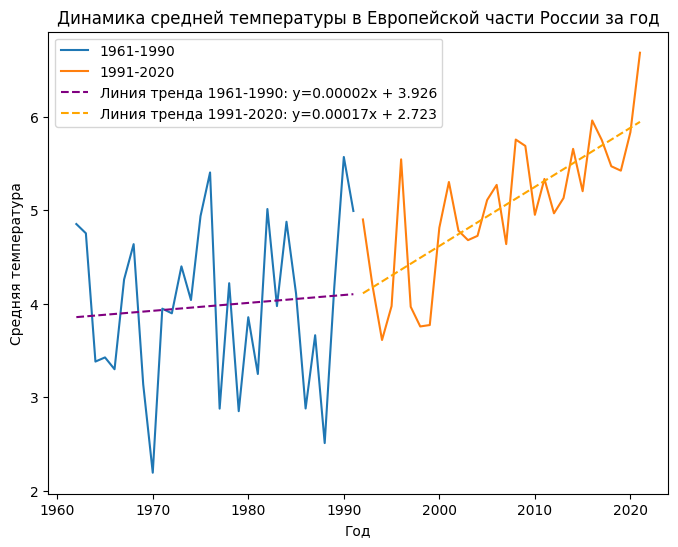

In [25]:
df_1961_1990 = mainDataFrame['1961-01-01':'1990-12-31']
df_1991_2020 = mainDataFrame['1991-01-01':'2020-12-31']
df_1961_1990 = df_1961_1990[df_1961_1990['Индекс ВМО'].isin(zones_FGR_df[0]['Индекс ВМО'])]
df_1991_2020 = df_1991_2020[df_1991_2020['Индекс ВМО'].isin(zones_FGR_df[0]['Индекс ВМО'])]

df_1961_1990_year = df_1961_1990['Средняя температура воздуха'].resample("YE").mean()
group_1 = df_1961_1990_year.values

df_1991_2020_year = df_1991_2020['Средняя температура воздуха'].resample("YE").mean()
group_2 = df_1991_2020_year.values

groups = {'group_1': group_1, 'group_2': group_2 }

checkNormality(groups)
# checkHomoscedasticity(groups)

print(f'Среднее значение {np.mean(group_1):.3f}, {np.mean(group_2):.3f}')
print(f'Медиана {np.median(group_1):.3f}, {np.median(group_2):.3f}')
print(f'Размах значений {range(group_1):.3f}, {range(group_2):.3f}')
print(f'Среднеквадратичное отклонение {np.std(group_1):.3f}, {np.std(group_2):.3f}')

res = oneFactorANOVA(groups)
if res < 0.05:
    print(f'Отвергаем гипотезу Н0, присутствует значимое различие между группами (p_value = {res:.12f})')
else:
    print(f'Принимаем гипотезу Н0, отсутсвует значимое различие между группами (p_value = {res:.12f})')

plt.figure(figsize=(8, 6))
plt.boxplot([group_1, group_2], labels=['1961-1990', '1991-2020'])
plt.title('Средние температуры в Приамурье и Приморье за год')
plt.ylabel('Средняя температура')
plt.xlabel('Период')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(df_1961_1990_year.index, group_1, label='1961-1990')
plt.plot(df_1991_2020_year.index, group_2, label='1991-2020')

x_values_1961_1990 = mdates.date2num(df_1961_1990_year.index)
x_values_1991_2020 = mdates.date2num(df_1991_2020_year.index)

z_1 = np.polyfit(x_values_1961_1990, group_1, 1)
p_1 = np.poly1d(z_1)
plt.plot(df_1961_1990_year.index, p_1(x_values_1961_1990), color='purple', linestyle='--', label=f'Линия тренда 1961-1990: y={z_1[0]:.5f}x + {z_1[1]:.3f}')

z_2 = np.polyfit(x_values_1991_2020, group_2, 1)
p_2 = np.poly1d(z_2)
plt.plot(df_1991_2020_year.index, p_2(x_values_1991_2020), color='orange', linestyle='--', label=f'Линия тренда 1991-2020: y={z_2[0]:.5f}x + {z_2[1]:.3f}')

plt.title('Динамика средней температуры в Европейской части России за год')
plt.xlabel('Год')
plt.ylabel('Средняя температура')
plt.legend()
plt.show()

### Средняя Сибирь

Образец из группы group_1 выглядит как нормальное распределение (не отвергаем H0) (p = 0.323800934518732)
Образец из группы group_2 выглядит как нормальное распределение (не отвергаем H0) (p = 0.7903788336306264)
Дисперсии однородны (гомоскедастичность не отвергается) (1.520992716649224 < 4.18296428905827)
Среднее значение -9.277, -7.763
Медиана -9.338, -7.812
Размах значений 1.200, 1.809
Среднеквадратичное отклонение 0.730, 1.302
Отвергаем гипотезу Н0, присутствует значимое различие между группами (p_value = 0.000001026449)


/var/folders/75/629qfrdj4fd2m28hk_zpnkrc0000gn/T/ipykernel_91704/3586996209.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['1961-1990', '1991-2020'])


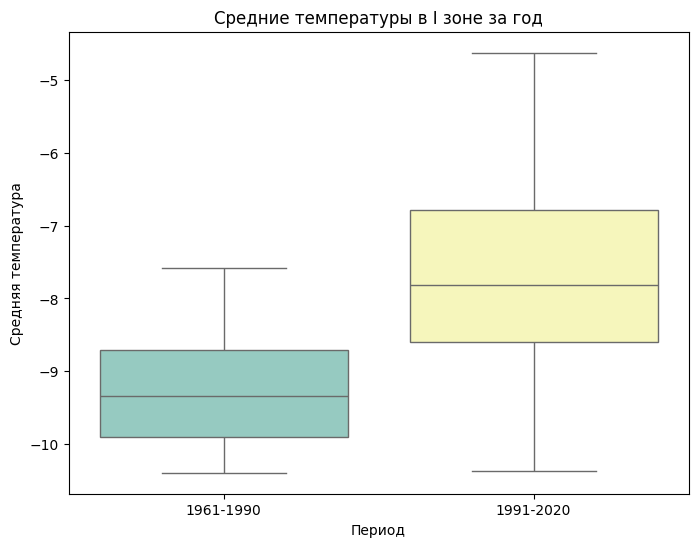

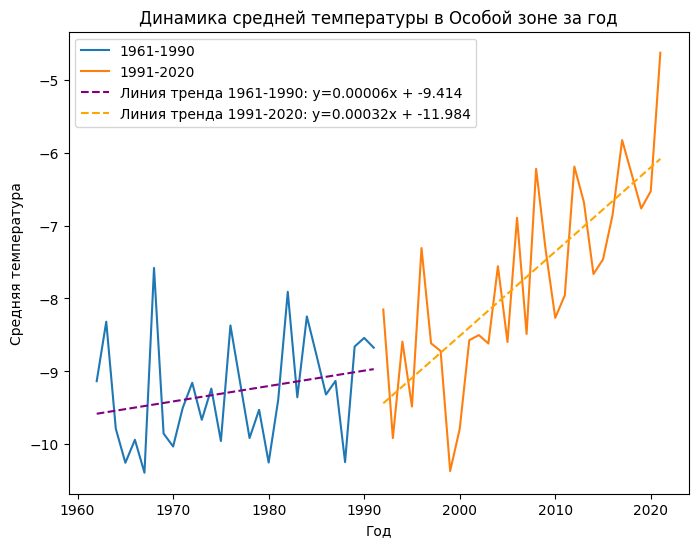

In [21]:
df_1961_1990 = mainDataFrame['1961-01-01':'1990-12-31']
df_1991_2020 = mainDataFrame['1991-01-01':'2020-12-31']
df_1961_1990 = df_1961_1990[df_1961_1990['Индекс ВМО'].isin(zones_Climate_df[4]['Индекс ВМО'])]
df_1991_2020 = df_1991_2020[df_1991_2020['Индекс ВМО'].isin(zones_Climate_df[4]['Индекс ВМО'])]

df_1961_1990_year = df_1961_1990['Средняя температура воздуха'].resample("YE").mean()
group_1 = df_1961_1990_year.values

df_1991_2020_year = df_1991_2020['Средняя температура воздуха'].resample("YE").mean()
group_2 = df_1991_2020_year.values

groups = {'group_1': group_1, 'group_2': group_2 }

checkNormality(groups)
checkHomoscedasticity(groups)

print(f'Среднее значение {np.mean(group_1):.3f}, {np.mean(group_2):.3f}')
print(f'Медиана {np.median(group_1):.3f}, {np.median(group_2):.3f}')
print(f'Размах значений {range(group_1):.3f}, {range(group_2):.3f}')
print(f'Среднеквадратичное отклонение {np.std(group_1):.3f}, {np.std(group_2):.3f}')

res = oneFactorANOVA(groups)
if res < 0.05:
    print(f'Отвергаем гипотезу Н0, присутствует значимое различие между группами (p_value = {res:.12f})')
else:
    print(f'Принимаем гипотезу Н0, отсутсвует значимое различие между группами (p_value = {res:.12f})')

plt.figure(figsize=(8, 6))
ax = sns.boxplot(data=[group_1, group_2], palette="Set3")
ax.set_xticklabels(['1961-1990', '1991-2020'])
plt.title('Средние температуры в I зоне за год')
plt.ylabel('Средняя температура')
plt.xlabel('Период')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(df_1961_1990_year.index, group_1, label='1961-1990')
plt.plot(df_1991_2020_year.index, group_2, label='1991-2020')

x_values_1961_1990 = mdates.date2num(df_1961_1990_year.index)
x_values_1991_2020 = mdates.date2num(df_1991_2020_year.index)

z_1 = np.polyfit(x_values_1961_1990, group_1, 1)
p_1 = np.poly1d(z_1)
plt.plot(df_1961_1990_year.index, p_1(x_values_1961_1990), color='purple', linestyle='--', label=f'Линия тренда 1961-1990: y={z_1[0]:.5f}x + {z_1[1]:.3f}')

z_2 = np.polyfit(x_values_1991_2020, group_2, 1)
p_2 = np.poly1d(z_2)
plt.plot(df_1991_2020_year.index, p_2(x_values_1991_2020), color='orange', linestyle='--', label=f'Линия тренда 1991-2020: y={z_2[0]:.5f}x + {z_2[1]:.3f}')

plt.title('Динамика средней температуры в Особой зоне за год')
plt.xlabel('Год')
plt.ylabel('Средняя температура')
plt.legend()
plt.show()

In [82]:
df_1961_1990_groups = df_1961_1990['Средняя температура воздуха'].groupby(df_1961_1990.index.month)
df_1991_2020_groups = df_1991_2020['Средняя температура воздуха'].groupby(df_1991_2020.index.month)

#### Зимние месяцы

Образец из группы group_1 выглядит как нормальное распределение (не отвергаем H0) (p = 0.36189632114281445)
Образец из группы group_2 выглядит как нормальное распределение (не отвергаем H0) (p = 0.08533988569259329)
Дисперсии однородны (гомоскедастичность не отвергается) (1.1311827245928565 < 4.18296428905827)
Среднее значение -24.245, -23.692
Медиана -23.953, -23.544
Размах значений 1.791, 1.140
Среднеквадратичное отклонение 1.498, 1.312
Принимаем гипотезу Н0, отсутсвует значимое различие между группами (p_value = 0.140562723391)


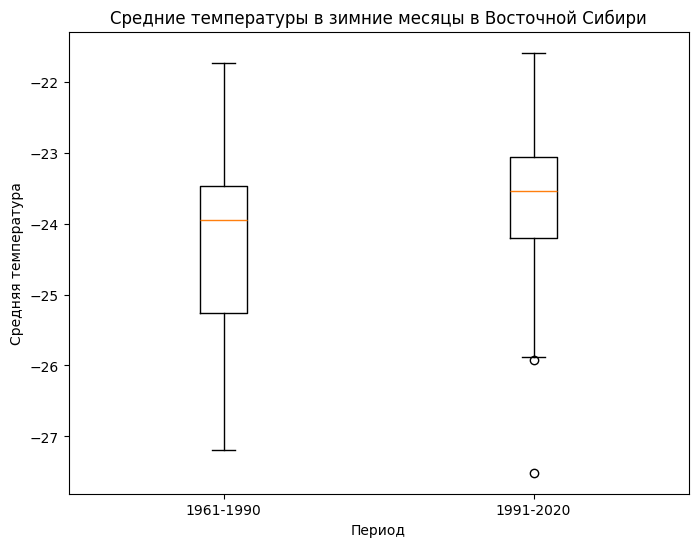

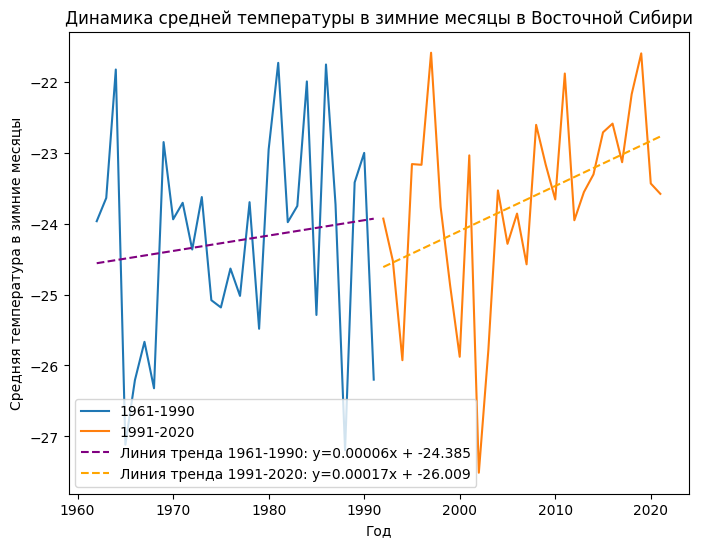

In [104]:
df_1961_1990 = mainDataFrame['1961-01-01':'1990-12-31']
df_1991_2020 = mainDataFrame['1991-01-01':'2020-12-31']
df_1961_1990 = df_1961_1990[df_1961_1990['Индекс ВМО'].isin(zones_FGR_df[5]['Индекс ВМО'])]
df_1991_2020 = df_1991_2020[df_1991_2020['Индекс ВМО'].isin(zones_FGR_df[5]['Индекс ВМО'])] 

df_1961_1990_groups = df_1961_1990['Средняя температура воздуха'].groupby(df_1961_1990.index.month)
df_1991_2020_groups = df_1991_2020['Средняя температура воздуха'].groupby(df_1991_2020.index.month)

df_1961_1990_winter = pd.concat([df_1961_1990_groups.get_group(12), df_1961_1990_groups.get_group(1), df_1961_1990_groups.get_group(2)])
df_1961_1990_winter = df_1961_1990_winter.resample("YE").mean()
group_1 = df_1961_1990_winter.values

df_1991_2020_winter = pd.concat([df_1991_2020_groups.get_group(12), df_1991_2020_groups.get_group(1), df_1991_2020_groups.get_group(2)])
df_1991_2020_winter = df_1991_2020_winter.resample("YE").mean()
group_2 = df_1991_2020_winter.values

groups = {'group_1': group_1, 'group_2': group_2 }

checkNormality(groups)
checkHomoscedasticity(groups)

print(f'Среднее значение {np.mean(group_1):.3f}, {np.mean(group_2):.3f}')
print(f'Медиана {np.median(group_1):.3f}, {np.median(group_2):.3f}')
print(f'Размах значений {range(group_1):.3f}, {range(group_2):.3f}')
print(f'Среднеквадратичное отклонение {np.std(group_1):.3f}, {np.std(group_2):.3f}')

res = oneFactorANOVA(groups)
if res[-1] < 0.05:
    print(f'Отвергаем гипотезу Н0, присутствует значимое различие между группами (p_value = {res[-1]:.12f})')
else:
    print(f'Принимаем гипотезу Н0, отсутсвует значимое различие между группами (p_value = {res[-1]:.12f})')
    
plt.figure(figsize=(8, 6))
plt.boxplot([group_1, group_2], labels=['1961-1990', '1991-2020'])
plt.title('Средние температуры в зимние месяцы в Восточной Сибири')
plt.ylabel('Средняя температура')
plt.xlabel('Период')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(df_1961_1990_year.index, group_1, label='1961-1990')
plt.plot(df_1991_2020_year.index, group_2, label='1991-2020')

x_values_1961_1990 = mdates.date2num(df_1961_1990_winter.index)
x_values_1991_2020 = mdates.date2num(df_1991_2020_winter.index)

z_1 = np.polyfit(x_values_1961_1990, group_1, 1)
p_1 = np.poly1d(z_1)
plt.plot(df_1961_1990_winter.index, p_1(x_values_1961_1990), color='purple', linestyle='--', label=f'Линия тренда 1961-1990: y={z_1[0]:.5f}x + {z_1[1]:.3f}')

z_2 = np.polyfit(x_values_1991_2020, group_2, 1)
p_2 = np.poly1d(z_2)
plt.plot(df_1991_2020_winter.index, p_2(x_values_1991_2020), color='orange', linestyle='--', label=f'Линия тренда 1991-2020: y={z_2[0]:.5f}x + {z_2[1]:.3f}')

plt.title('Динамика средней температуры в зимние месяцы в Восточной Сибири')
plt.xlabel('Год')
plt.ylabel('Средняя температура в зимние месяцы')
plt.legend()
plt.show()

#### Летние месяцы

Образец из группы group_1 выглядит как нормальное распределение (не отвергаем H0) (p = 0.3467444055488378)
Образец из группы group_2 выглядит как нормальное распределение (не отвергаем H0) (p = 0.07452581766560527)
Дисперсии однородны (гомоскедастичность не отвергается) (1.226588625994502 < 4.18296428905827)
Среднее значение 9.665, 10.785
Медиана 9.696, 10.882
Размах значений 0.606, 0.804
Среднеквадратичное отклонение 0.474, 0.596
Отвергаем гипотезу Н0, присутствует значимое различие между группами (p_value = 0.000000000085)


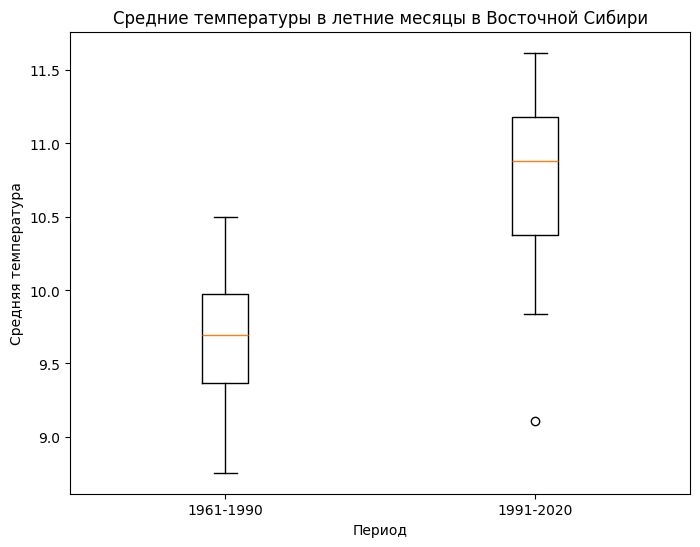

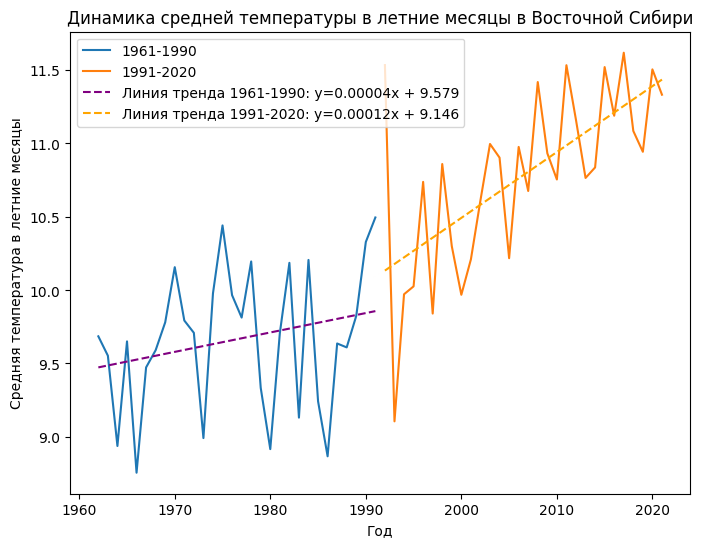

In [105]:
df_1961_1990 = mainDataFrame['1961-01-01':'1990-12-31']
df_1991_2020 = mainDataFrame['1991-01-01':'2020-12-31']
df_1961_1990 = df_1961_1990[df_1961_1990['Индекс ВМО'].isin(zones_FGR_df[5]['Индекс ВМО'])]
df_1991_2020 = df_1991_2020[df_1991_2020['Индекс ВМО'].isin(zones_FGR_df[5]['Индекс ВМО'])] 

df_1961_1990_groups = df_1961_1990['Средняя температура воздуха'].groupby(df_1961_1990.index.month)
df_1991_2020_groups = df_1991_2020['Средняя температура воздуха'].groupby(df_1991_2020.index.month)

df_1961_1990_summer = pd.concat([df_1961_1990_groups.get_group(6), df_1961_1990_groups.get_group(7), df_1961_1990_groups.get_group(8)])
df_1961_1990_summer = df_1961_1990_summer.resample("YE").mean()
group_1 = df_1961_1990_summer.values

df_1991_2020_summer = pd.concat([df_1991_2020_groups.get_group(6), df_1991_2020_groups.get_group(7), df_1991_2020_groups.get_group(8)])
df_1991_2020_summer = df_1991_2020_summer.resample("YE").mean()
group_2 = df_1991_2020_summer.values

groups = {'group_1': group_1, 'group_2': group_2 }
checkNormality(groups)
checkHomoscedasticity(groups)

print(f'Среднее значение {np.mean(group_1):.3f}, {np.mean(group_2):.3f}')
print(f'Медиана {np.median(group_1):.3f}, {np.median(group_2):.3f}')
print(f'Размах значений {range(group_1):.3f}, {range(group_2):.3f}')
print(f'Среднеквадратичное отклонение {np.std(group_1):.3f}, {np.std(group_2):.3f}')

res = oneFactorANOVA(groups)
if res[-1] < 0.05:
    print(f'Отвергаем гипотезу Н0, присутствует значимое различие между группами (p_value = {res[-1]:.12f})')
else:
    print(f'Принимаем гипотезу Н0, отсутсвует значимое различие между группами (p_value = {res[-1]:.12f})')

plt.figure(figsize=(8, 6))
plt.boxplot([group_1, group_2], labels=['1961-1990', '1991-2020'])
plt.title('Средние температуры в летние месяцы в Восточной Сибири')
plt.ylabel('Средняя температура')
plt.xlabel('Период')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(df_1961_1990_year.index, group_1, label='1961-1990')
plt.plot(df_1991_2020_year.index, group_2, label='1991-2020')

x_values_1961_1990 = mdates.date2num(df_1961_1990_winter.index)
x_values_1991_2020 = mdates.date2num(df_1991_2020_winter.index)

z_1 = np.polyfit(x_values_1961_1990, group_1, 1)
p_1 = np.poly1d(z_1)
plt.plot(df_1961_1990_winter.index, p_1(x_values_1961_1990), color='purple', linestyle='--', label=f'Линия тренда 1961-1990: y={z_1[0]:.5f}x + {z_1[1]:.3f}')

z_2 = np.polyfit(x_values_1991_2020, group_2, 1)
p_2 = np.poly1d(z_2)
plt.plot(df_1991_2020_winter.index, p_2(x_values_1991_2020), color='orange', linestyle='--', label=f'Линия тренда 1991-2020: y={z_2[0]:.5f}x + {z_2[1]:.3f}')


plt.title('Динамика средней температуры в летние месяцы в Восточной Сибири')
plt.xlabel('Год')
plt.ylabel('Средняя температура в летние месяцы')
plt.legend()
plt.show()

#### Отклонения от среднегодовых

Образец из группы group_1 выглядит как нормальное распределение (не отвергаем H0) (p = 0.323800934518732)
Образец из группы group_2 выглядит как нормальное распределение (не отвергаем H0) (p = 0.7903788336306264)
Дисперсии однородны (гомоскедастичность не отвергается) (1.520992716649224 < 4.18296428905827)
Принимаем гипотезу Н0, отсутсвует значимое различие между группами (p_value = 0.999999999999998)


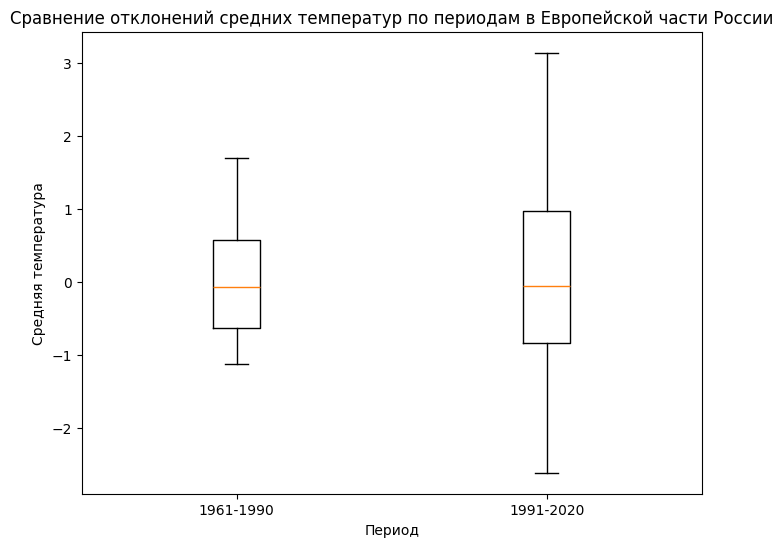

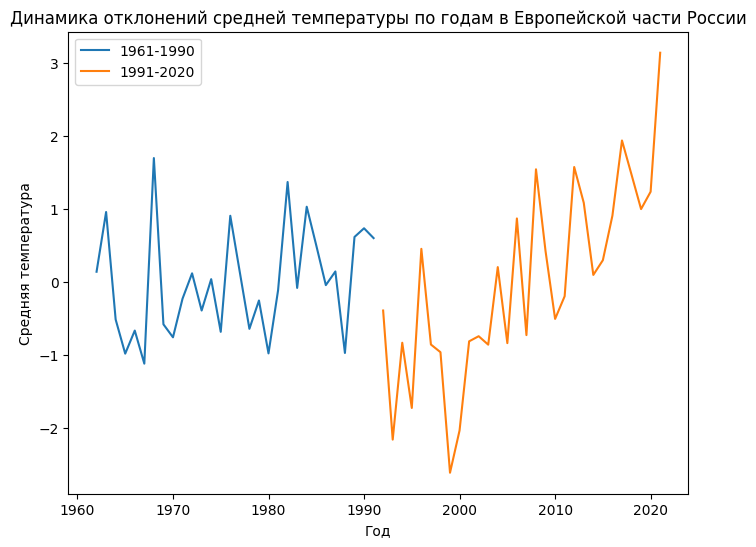

In [36]:
df_1961_1990_year_mean = df_1961_1990_year.mean()
res = df_1961_1990_year - df_1961_1990_year_mean
group_1 = res.values

df_1991_2020_year_mean = df_1991_2020_year.mean()
res = df_1991_2020_year - df_1991_2020_year_mean
group_2 = res.values

groups = {'group_1': group_1, 'group_2': group_2 }
checkNormality(groups)
checkHomoscedasticity(groups)
res = oneFactorANOVA(groups)
if res[-1] < 0.05:
    print('Отвергаем гипотезу Н0, присутствует значимое различие между группами (p_value = {})'.format(res[-1]))
else:
    print('Принимаем гипотезу Н0, отсутсвует значимое различие между группами (p_value = {})'.format(res[-1]))

plt.figure(figsize=(8, 6))
plt.boxplot([group_1, group_2], labels=['1961-1990', '1991-2020'])
plt.title('Сравнение отклонений средних температур по периодам в Европейской части России')
plt.ylabel('Средняя температура')
plt.xlabel('Период')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(df_1961_1990_year.index, group_1, label='1961-1990')
plt.plot(df_1991_2020_year.index, group_2, label='1991-2020')
plt.title('Динамика отклонений средней температуры по годам в Европейской части России')
plt.xlabel('Год')
plt.ylabel('Средняя температура')
plt.legend()
plt.show()

## TWO-FACTOR ANOVA (ФИЗИКО-ГЕОГРАФИЧЕСКИЕ РЕГИОНЫ)

Образец из группы group_1 выглядит как нормальное распределение (не отвергаем H0) (p = 0.3968144186972059)
Образец из группы group_2 выглядит как нормальное распределение (не отвергаем H0) (p = 0.12378564778810652)
Образец из группы group_3 НЕ выглядит как нормальное распределение (отвергаем H0) (p = 0.02299960570728715)
Образец из группы group_4 НЕ выглядит как нормальное распределение (отвергаем H0) (p = 0.01141444368706378)
Образец из группы group_5 выглядит как нормальное распределение (не отвергаем H0) (p = 0.5264664661965971)
Образец из группы group_6 выглядит как нормальное распределение (не отвергаем H0) (p = 0.29313480147438165)
Образец из группы group_7 выглядит как нормальное распределение (не отвергаем H0) (p = 0.1426791972561624)
Образец из группы group_8 выглядит как нормальное распределение (не отвергаем H0) (p = 0.694645999261794)
Образец из группы group_9 выглядит как нормальное распределение (не отвергаем H0) (p = 0.5303663293254657)
Образец из группы group_10 выгляди

/var/folders/75/629qfrdj4fd2m28hk_zpnkrc0000gn/T/ipykernel_83419/977558414.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=45)


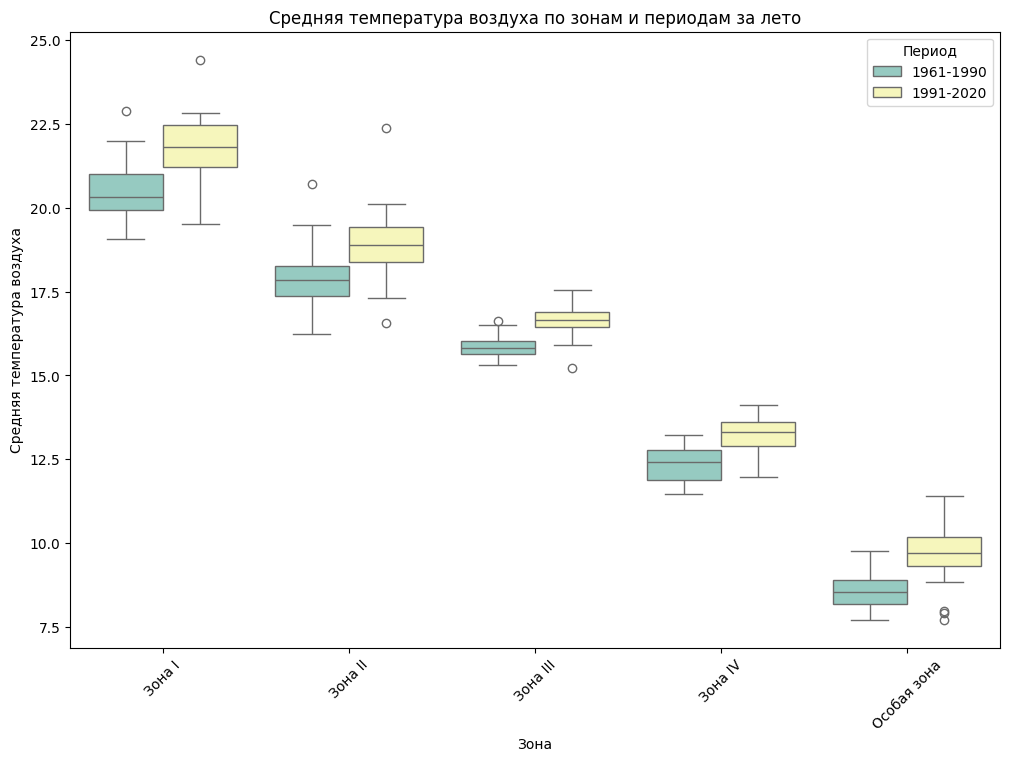

In [110]:
df_1961_1990 = mainDataFrame['1961-01-01':'1990-12-31']
df_1991_2020 = mainDataFrame['1991-01-01':'2020-12-31']

regions_periods = {
    'Зона I': ['1961-1990', '1991-2020'],
    'Зона II': ['1961-1990', '1991-2020'],
    'Зона III': ['1961-1990', '1991-2020'],
    'Зона IV': ['1961-1990', '1991-2020'],
    'Особая зона': ['1961-1990', '1991-2020'],
}

periods = ['1961-1990', '1991-2020']
dfs = []
i = 0

for region, _ in regions_periods.items():
    for period in periods:
        if period == '1961-1990':
            data = mainDataFrame['1961-01-01':'1990-12-31']
        else:
            data = mainDataFrame['1991-01-01':'2020-12-31']
        filtered_data = data[data['Индекс ВМО'].isin(zones_Climate_df[i]['Индекс ВМО'])]
        filtered_data = filtered_data[filtered_data.index.month.isin([6, 7, 8])]
        resampled_data = filtered_data['Средняя температура воздуха'].resample("YE").mean()
        df = pd.DataFrame({'Значение': resampled_data.values, 'Регион': region, 'Период': period})
        dfs.append(df)
    i += 1

groups = pd.concat(dfs, ignore_index=True)

values_array = groups['Значение'].values
group_1 = values_array[:30]
group_2 = values_array[31:60]
group_3 = values_array[61:90]
group_4 = values_array[91:120]
group_5 = values_array[121:150]
group_6 = values_array[151:180]
group_7 = values_array[181:210]
group_8 = values_array[211:240]
group_9 = values_array[241:270]
group_10 = values_array[271:300]

arrays = {'group_1': group_1, 'group_2': group_2, 'group_3': group_3, 'group_4': group_4, 'group_5': group_5, 'group_6': group_6, 'group_7': group_7, 'group_8': group_8, 'group_9': group_9, 'group_10': group_10 }

checkNormality(arrays)
checkHomoscedasticity(arrays)

res = twoFactorANOVA(groups)
if res[15] < 0.05:
    print('Отвергаем гипотезу Н0, присутствует значимое различие между группами по фактору 1 (p_value = {})'.format(res[15]))
else:
    print('Принимаем гипотезу Н0, отсутсвует значимое различие между группами по фактору 1 (p_value = {})'.format(res[15]))
    
if res[17] < 0.05:
    print('Отвергаем гипотезу Н0, присутствует значимое различие между группами по фактору 2 (p_value = {})'.format(res[17]))
else:
    print('Принимаем гипотезу Н0, отсутсвует значимое различие между группами по фактору 2 (p_value = {})'.format(res[17]))

if res[19] < 0.05:
    print('Отвергаем гипотезу Н0, присутствует значимое различие между группами по взаимодействию факторов (p_value = {})'.format(res[19]))
else:
    print('Принимаем гипотезу Н0, отсутсвует значимое различие между группами по взаимодействию факторов (p_value = {})'.format(res[19]))

plt.figure(figsize=(12, 8))
plt.title('Средняя температура воздуха по зонам и периодам за лето')
boxplot = sns.boxplot(x='Регион', y='Значение', hue='Период', data=groups, palette='Set3')
boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=45)
plt.xlabel('Зона')
plt.ylabel('Средняя температура воздуха')
plt.show()


In [89]:
groups

,Значение,Регион,Период
0,17.555365,Европейская часть России,1961-1990
1,15.953344,Европейская часть России,1961-1990
2,16.341003,Европейская часть России,1961-1990
3,16.698732,Европейская часть России,1961-1990
4,16.054373,Европейская часть России,1961-1990
...,...,...,...
355,11.618699,Восточная Сибирь,1991-2020
356,11.085276,Восточная Сибирь,1991-2020
357,10.943329,Восточная Сибирь,1991-2020
358,11.505226,Восточная Сибирь,1991-2020


### Летние месяцы

Образец из группы group_1 выглядит как нормальное распределение (не отвергаем H0) (p = 0.742555853915649)
Образец из группы group_2 выглядит как нормальное распределение (не отвергаем H0) (p = 0.20316155660892737)
Образец из группы group_3 выглядит как нормальное распределение (не отвергаем H0) (p = 0.6146687103423627)
Образец из группы group_4 выглядит как нормальное распределение (не отвергаем H0) (p = 0.36729316904316145)
Образец из группы group_5 выглядит как нормальное распределение (не отвергаем H0) (p = 0.841828778965657)
Образец из группы group_6 выглядит как нормальное распределение (не отвергаем H0) (p = 0.12147668589811678)
Дисперсии однородны (гомоскедастичность не отвергается) (1.25276278147505 < 2.244087025028735)
Отвергаем гипотезу Н0, присутствует значимое различие между группами (p_value = 1.1102230246251565e-16)


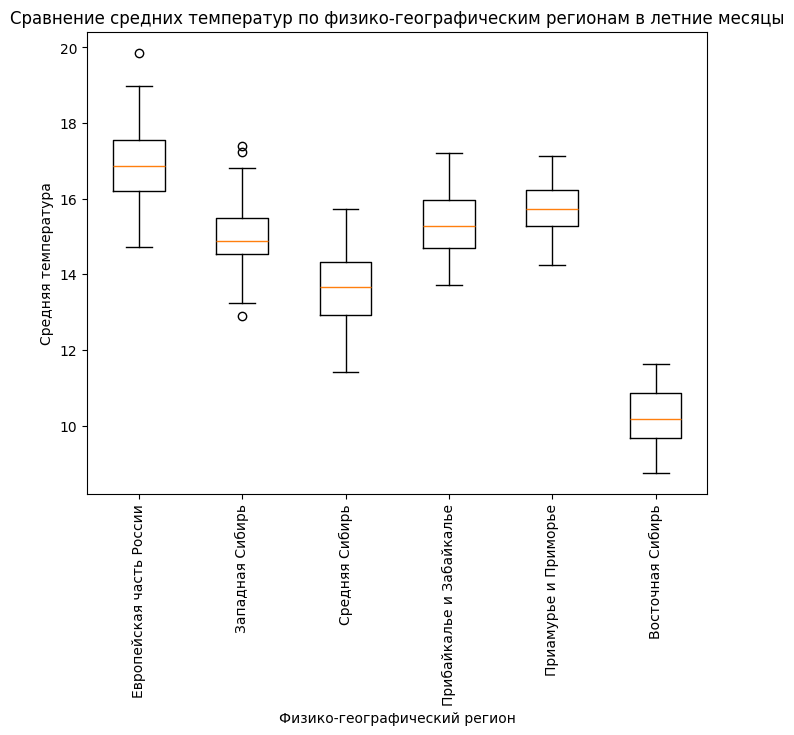

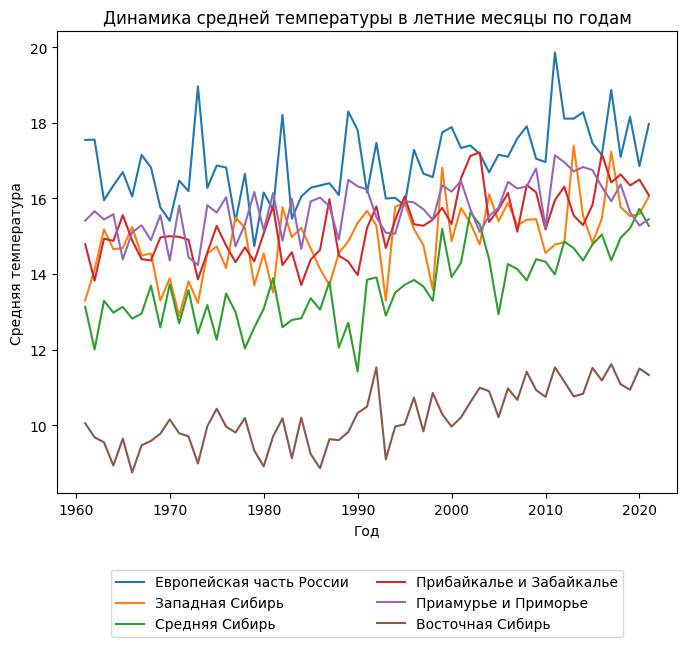

In [56]:
df_European = mainDataFrame[mainDataFrame['Индекс ВМО'].isin(zones_FGR_df[0]['Индекс ВМО'])]
df_West_Siberia = mainDataFrame[mainDataFrame['Индекс ВМО'].isin(zones_FGR_df[1]['Индекс ВМО'])]
df_Middle_Siberia = mainDataFrame[mainDataFrame['Индекс ВМО'].isin(zones_FGR_df[2]['Индекс ВМО'])]
df_Baikal = mainDataFrame[mainDataFrame['Индекс ВМО'].isin(zones_FGR_df[3]['Индекс ВМО'])]
df_Seaside = mainDataFrame[mainDataFrame['Индекс ВМО'].isin(zones_FGR_df[4]['Индекс ВМО'])]
df_East_Siberia = mainDataFrame[mainDataFrame['Индекс ВМО'].isin(zones_FGR_df[5]['Индекс ВМО'])]

df_European_summer = df_European['Средняя температура воздуха'].groupby(df_European.index.month)
df_European_summer = pd.concat([df_European_summer.get_group(6), df_European_summer.get_group(7), df_European_summer.get_group(8)])
df_European_summer = df_European_summer.resample("YE").mean()
group_1 = df_European_summer.values

df_West_Siberia_summer = df_West_Siberia['Средняя температура воздуха'].groupby(df_West_Siberia.index.month)
df_West_Siberia_summer = pd.concat([df_West_Siberia_summer.get_group(6), df_West_Siberia_summer.get_group(7), df_West_Siberia_summer.get_group(8)])
df_West_Siberia_summer = df_West_Siberia_summer.resample("YE").mean()
group_2 = df_West_Siberia_summer.values

df_Middle_Siberia_summer = df_Middle_Siberia['Средняя температура воздуха'].groupby(df_Middle_Siberia.index.month)
df_Middle_Siberia_summer = pd.concat([df_Middle_Siberia_summer.get_group(6), df_Middle_Siberia_summer.get_group(7), df_Middle_Siberia_summer.get_group(8)])
df_Middle_Siberia_summer = df_Middle_Siberia_summer.resample("YE").mean()
group_3 = df_Middle_Siberia_summer.values

df_Baikal_summer = df_Baikal['Средняя температура воздуха'].groupby(df_Baikal.index.month)
df_Baikal_summer = pd.concat([df_Baikal_summer.get_group(6), df_Baikal_summer.get_group(7), df_Baikal_summer.get_group(8)])
df_Baikal_summer = df_Baikal_summer.resample("YE").mean()
group_4 = df_Baikal_summer.values

df_Seaside_summer = df_Seaside['Средняя температура воздуха'].groupby(df_Seaside.index.month)
df_Seaside_summer = pd.concat([df_Seaside_summer.get_group(6), df_Seaside_summer.get_group(7), df_Seaside_summer.get_group(8)])
df_Seaside_summer = df_Seaside_summer.resample("YE").mean()
group_5 = df_Seaside_summer.values

df_East_Siberia_summer = df_East_Siberia['Средняя температура воздуха'].groupby(df_East_Siberia.index.month)
df_East_Siberia_summer = pd.concat([df_East_Siberia_summer.get_group(6), df_East_Siberia_summer.get_group(7), df_East_Siberia_summer.get_group(8)])
df_East_Siberia_summer = df_East_Siberia_summer.resample("YE").mean()
group_6 = df_East_Siberia_summer.values

groups = {'group_1': group_1, 'group_2': group_2, 'group_3': group_3, 'group_4': group_4, 'group_5': group_5, 'group_6': group_6 }
checkNormality(groups)
checkHomoscedasticity(groups)

res = oneFactorANOVA(groups)
if res[-1] < 0.05:
    print('Отвергаем гипотезу Н0, присутствует значимое различие между группами (p_value = {})'.format(res[-1]))
else:
    print('Принимаем гипотезу Н0, отсутсвует значимое различие между группами (p_value = {})'.format(res[-1]))

plt.figure(figsize=(8, 6))
plt.boxplot([group_1, group_2, group_3, group_4, group_5, group_6], labels=['Европейская часть России', 'Западная Сибирь', 'Средняя Сибирь', 'Прибайкалье и Забайкалье', 'Приамурье и Приморье', 'Восточная Сибирь'])
plt.title('Сравнение средних температур по физико-географическим регионам в летние месяцы')
plt.ylabel('Средняя температура')
plt.xlabel('Физико-географический регион')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(df_European_summer.index, group_1, label='Европейская часть России')
plt.plot(df_West_Siberia_summer.index, group_2, label='Западная Сибирь')
plt.plot(df_Middle_Siberia_summer.index, group_3, label='Средняя Сибирь')
plt.plot(df_Baikal_summer.index, group_4, label='Прибайкалье и Забайкалье')
plt.plot(df_Seaside_summer.index, group_5, label='Приамурье и Приморье')
plt.plot(df_East_Siberia_summer.index, group_6, label='Восточная Сибирь')
plt.title('Динамика средней температуры в летние месяцы по годам')
plt.xlabel('Год')
plt.ylabel('Средняя температура')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.show()



In [25]:
df_European_summer = pd.DataFrame(df_European_summer )
df_West_Siberia_summer = pd.DataFrame(df_West_Siberia_summer)
df_Middle_Siberia_summer = pd.DataFrame(df_Middle_Siberia_summer)

df_European_summer.reset_index(drop=True, inplace=True)
df_Middle_Siberia_summer.reset_index(drop=True, inplace=True)

groupsAll = pd.concat([df_European_summer, df_West_Siberia_summer['Средняя температура воздуха']], axis=1)
groupsAll = pd.concat([groupsAll, df_Middle_Siberia_summer['Средняя температура воздуха']], axis=1)


,Средняя температура воздуха
Дата,
1960,17.547521
1961,17.555365
1962,15.953344
1963,16.341003
1964,16.698732


### Зимние месяцы 

Образец из группы group_1 выглядит как нормальное распределение (не отвергаем H0) (p = 0.32216880329506503)
Образец из группы group_2 выглядит как нормальное распределение (не отвергаем H0) (p = 0.29634000803345245)
Образец из группы group_3 выглядит как нормальное распределение (не отвергаем H0) (p = 0.7848029921793925)
Образец из группы group_4 выглядит как нормальное распределение (не отвергаем H0) (p = 0.3150159913953381)
Образец из группы group_5 выглядит как нормальное распределение (не отвергаем H0) (p = 0.4079852501091058)
Образец из группы group_6 выглядит как нормальное распределение (не отвергаем H0) (p = 0.0730766256610046)
Дисперсии однородны (гомоскедастичность не отвергается) (1.6189796745858078 < 2.244087025028735)
Отвергаем гипотезу Н0, присутствует значимое различие между группами (p_value = 1.1102230246251565e-16)


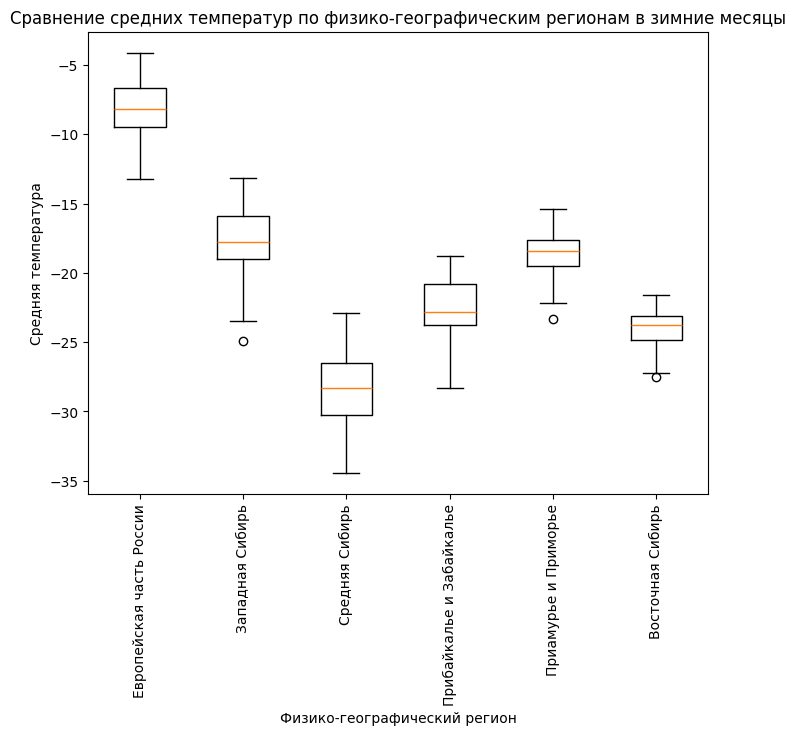

NameError: name 'df_European_year' is not defined

<Figure size 800x600 with 0 Axes>

In [57]:
df_European = mainDataFrame[mainDataFrame['Индекс ВМО'].isin(zones_FGR_df[0]['Индекс ВМО'])]
df_West_Siberia = mainDataFrame[mainDataFrame['Индекс ВМО'].isin(zones_FGR_df[1]['Индекс ВМО'])]
df_Middle_Siberia = mainDataFrame[mainDataFrame['Индекс ВМО'].isin(zones_FGR_df[2]['Индекс ВМО'])]
df_Baikal = mainDataFrame[mainDataFrame['Индекс ВМО'].isin(zones_FGR_df[3]['Индекс ВМО'])]
df_Seaside = mainDataFrame[mainDataFrame['Индекс ВМО'].isin(zones_FGR_df[4]['Индекс ВМО'])]
df_East_Siberia = mainDataFrame[mainDataFrame['Индекс ВМО'].isin(zones_FGR_df[5]['Индекс ВМО'])]

df_European_winter = df_European['Средняя температура воздуха'].groupby(df_European.index.month)
df_European_winter = pd.concat([df_European_winter.get_group(12), df_European_winter.get_group(1), df_European_winter.get_group(2)])
df_European_winter = df_European_winter.resample("YE").mean()
group_1 = df_European_winter.values

df_West_Siberia_winter = df_West_Siberia['Средняя температура воздуха'].groupby(df_West_Siberia.index.month)
df_West_Siberia_winter = pd.concat([df_West_Siberia_winter.get_group(12), df_West_Siberia_winter.get_group(1), df_West_Siberia_winter.get_group(2)])
df_West_Siberia_winter = df_West_Siberia_winter.resample("YE").mean()
group_2 = df_West_Siberia_winter.values

df_Middle_Siberia_winter = df_Middle_Siberia['Средняя температура воздуха'].groupby(df_Middle_Siberia.index.month)
df_Middle_Siberia_winter = pd.concat([df_Middle_Siberia_winter.get_group(12), df_Middle_Siberia_winter.get_group(1), df_Middle_Siberia_winter.get_group(2)])
df_Middle_Siberia_winter = df_Middle_Siberia_winter.resample("YE").mean()
group_3 = df_Middle_Siberia_winter.values

df_Baikal_winter = df_Baikal['Средняя температура воздуха'].groupby(df_Baikal.index.month)
df_Baikal_winter = pd.concat([df_Baikal_winter.get_group(12), df_Baikal_winter.get_group(1), df_Baikal_winter.get_group(2)])
df_Baikal_winter = df_Baikal_winter.resample("YE").mean()
group_4 = df_Baikal_winter.values

df_Seaside_winter = df_Seaside['Средняя температура воздуха'].groupby(df_Seaside.index.month)
df_Seaside_winter = pd.concat([df_Seaside_winter.get_group(12), df_Seaside_winter.get_group(1), df_Seaside_winter.get_group(2)])
df_Seaside_winter = df_Seaside_winter.resample("YE").mean()
group_5 = df_Seaside_winter.values

df_East_Siberia_winter = df_East_Siberia['Средняя температура воздуха'].groupby(df_East_Siberia.index.month)
df_East_Siberia_winter = pd.concat([df_East_Siberia_winter.get_group(12), df_East_Siberia_winter.get_group(1), df_East_Siberia_winter.get_group(2)])
df_East_Siberia_winter = df_East_Siberia_winter.resample("YE").mean()
group_6 = df_East_Siberia_winter.values

groups = {'group_1': group_1, 'group_2': group_2, 'group_3': group_3, 'group_4': group_4, 'group_5': group_5, 'group_6': group_6 }
checkNormality(groups)
checkHomoscedasticity(groups)

res = oneFactorANOVA(groups)
if res[-1] < 0.05:
    print('Отвергаем гипотезу Н0, присутствует значимое различие между группами (p_value = {})'.format(res[-1]))
else:
    print('Принимаем гипотезу Н0, отсутсвует значимое различие между группами (p_value = {})'.format(res[-1]))

plt.figure(figsize=(8, 6))
plt.boxplot([group_1, group_2, group_3, group_4, group_5, group_6], labels=['Европейская часть России', 'Западная Сибирь', 'Средняя Сибирь', 'Прибайкалье и Забайкалье', 'Приамурье и Приморье', 'Восточная Сибирь'])
plt.title('Сравнение средних температур по физико-географическим регионам в зимние месяцы')
plt.ylabel('Средняя температура')
plt.xlabel('Физико-географический регион')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(df_European_year.index, group_1, label='Европейская часть России')
plt.plot(df_West_Siberia_year.index, group_2, label='Западная Сибирь')
plt.plot(df_Middle_Siberia_year.index, group_3, label='Средняя Сибирь')
plt.plot(df_Baikal_year.index, group_4, label='Прибайкалье и Забайкалье')
plt.plot(df_Seaside_year.index, group_5, label='Приамурье и Приморье')
plt.plot(df_East_Siberia_year.index, group_6, label='Восточная Сибирь')
plt.title('Динамика средней температуры в зимние месяцы по годам')
plt.xlabel('Год')
plt.ylabel('Средняя температура')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.show()



### Среднегодовая

Образец из группы group_1 выглядит как нормальное распределение (не отвергаем H0) (p = 0.5316717115001097)
Образец из группы group_2 выглядит как нормальное распределение (не отвергаем H0) (p = 0.9894755957243355)
Образец из группы group_3 выглядит как нормальное распределение (не отвергаем H0) (p = 0.6217166994876273)
Образец из группы group_4 выглядит как нормальное распределение (не отвергаем H0) (p = 0.9489752205520844)
Образец из группы group_5 выглядит как нормальное распределение (не отвергаем H0) (p = 0.6266674471162872)
Образец из группы group_6 выглядит как нормальное распределение (не отвергаем H0) (p = 0.282113754071887)
Дисперсии однородны (гомоскедастичность не отвергается) (1.6890415002466315 < 2.244087025028735)
Отвергаем гипотезу Н0, присутствует значимое различие между группами (p_value = 1.1102230246251565e-16)


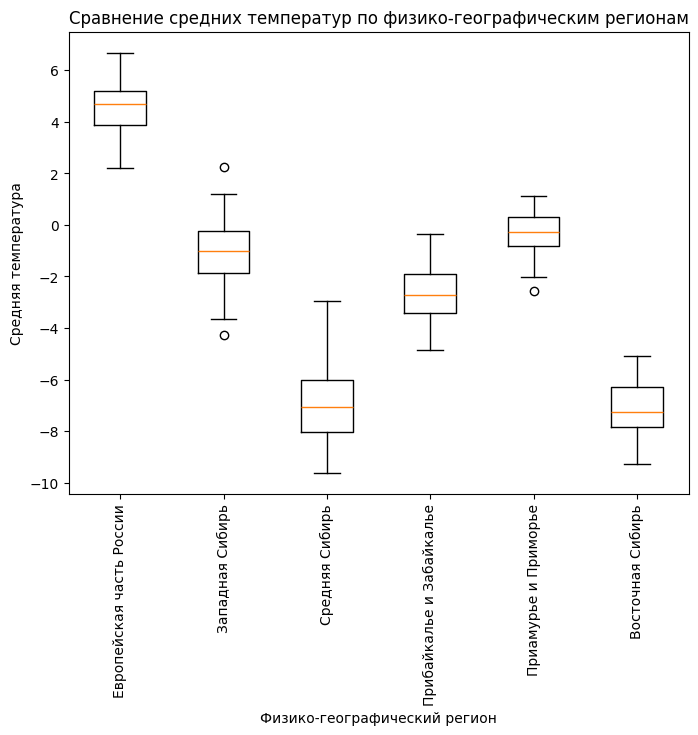

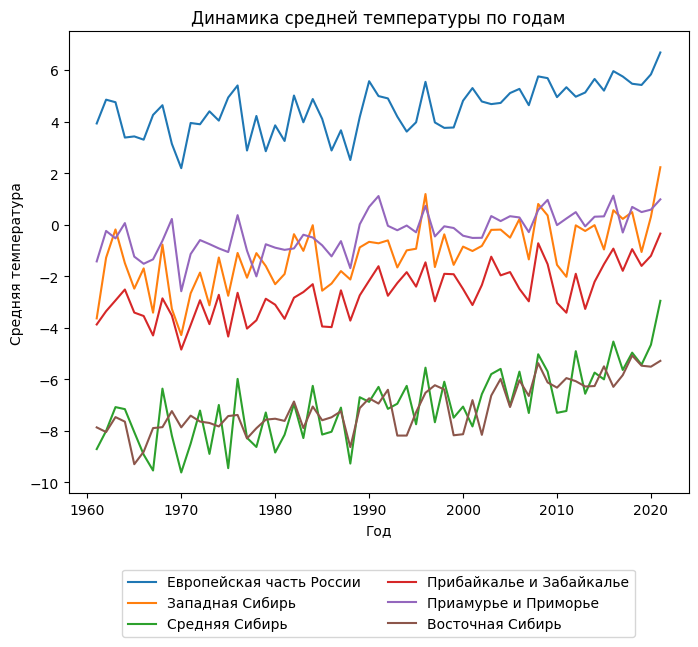

In [58]:
df_European = mainDataFrame[mainDataFrame['Индекс ВМО'].isin(zones_FGR_df[0]['Индекс ВМО'])]
df_West_Siberia = mainDataFrame[mainDataFrame['Индекс ВМО'].isin(zones_FGR_df[1]['Индекс ВМО'])]
df_Middle_Siberia = mainDataFrame[mainDataFrame['Индекс ВМО'].isin(zones_FGR_df[2]['Индекс ВМО'])]
df_Baikal = mainDataFrame[mainDataFrame['Индекс ВМО'].isin(zones_FGR_df[3]['Индекс ВМО'])]
df_Seaside = mainDataFrame[mainDataFrame['Индекс ВМО'].isin(zones_FGR_df[4]['Индекс ВМО'])]
df_East_Siberia = mainDataFrame[mainDataFrame['Индекс ВМО'].isin(zones_FGR_df[5]['Индекс ВМО'])]

df_European_year = df_European['Средняя температура воздуха'].resample("YE").mean()
group_1 = df_European_year.values

df_West_Siberia_year = df_West_Siberia['Средняя температура воздуха'].resample("YE").mean()
group_2 = df_West_Siberia_year.values

df_Middle_Siberia_year = df_Middle_Siberia['Средняя температура воздуха'].resample("YE").mean()
group_3 = df_Middle_Siberia_year.values

df_Baikal_year = df_Baikal['Средняя температура воздуха'].resample("YE").mean()
group_4 = df_Baikal_year.values

df_Seaside_year = df_Seaside['Средняя температура воздуха'].resample("YE").mean()
group_5 = df_Seaside_year.values

df_East_Siberia_year = df_East_Siberia['Средняя температура воздуха'].resample("YE").mean()
group_6 = df_East_Siberia_year.values

groups = {'group_1': group_1, 'group_2': group_2, 'group_3': group_3, 'group_4': group_4, 'group_5': group_5, 'group_6': group_6 }
checkNormality(groups)
checkHomoscedasticity(groups)

res = oneFactorANOVA(groups)
if res[-1] < 0.05:
    print('Отвергаем гипотезу Н0, присутствует значимое различие между группами (p_value = {})'.format(res[-1]))
else:
    print('Принимаем гипотезу Н0, отсутсвует значимое различие между группами (p_value = {})'.format(res[-1]))

plt.figure(figsize=(8, 6))
plt.boxplot([group_1, group_2, group_3, group_4, group_5, group_6], labels=['Европейская часть России', 'Западная Сибирь', 'Средняя Сибирь', 'Прибайкалье и Забайкалье', 'Приамурье и Приморье', 'Восточная Сибирь'])
plt.title('Сравнение средних температур по физико-географическим регионам')
plt.ylabel('Средняя температура')
plt.xlabel('Физико-географический регион')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(df_European_year.index, group_1, label='Европейская часть России')
plt.plot(df_West_Siberia_year.index, group_2, label='Западная Сибирь')
plt.plot(df_Middle_Siberia_year.index, group_3, label='Средняя Сибирь')
plt.plot(df_Baikal_year.index, group_4, label='Прибайкалье и Забайкалье')
plt.plot(df_Seaside_year.index, group_5, label='Приамурье и Приморье')
plt.plot(df_East_Siberia_year.index, group_6, label='Восточная Сибирь')
plt.title('Динамика средней температуры по годам')
plt.xlabel('Год')
plt.ylabel('Средняя температура')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.show()



### Отклонения от среднегодовых (дисперсии неоднородны)

Образец из группы group_1 выглядит как нормальное распределение (не отвергаем H0) (p = 0.5316717115001097)
Образец из группы group_2 выглядит как нормальное распределение (не отвергаем H0) (p = 0.9894755957243355)
Образец из группы group_3 выглядит как нормальное распределение (не отвергаем H0) (p = 0.6217166994876273)
Образец из группы group_4 выглядит как нормальное распределение (не отвергаем H0) (p = 0.9489752205520774)
Образец из группы group_5 выглядит как нормальное распределение (не отвергаем H0) (p = 0.6266674471162872)
Образец из группы group_6 выглядит как нормальное распределение (не отвергаем H0) (p = 0.282113754071887)
Дисперсии неоднородны (гомоскедастичность отвергается) (3.1418565436464996 > 2.244087025028735)
Принимаем гипотезу Н0, отсутсвует значимое различие между группами (p_value = 1.0)


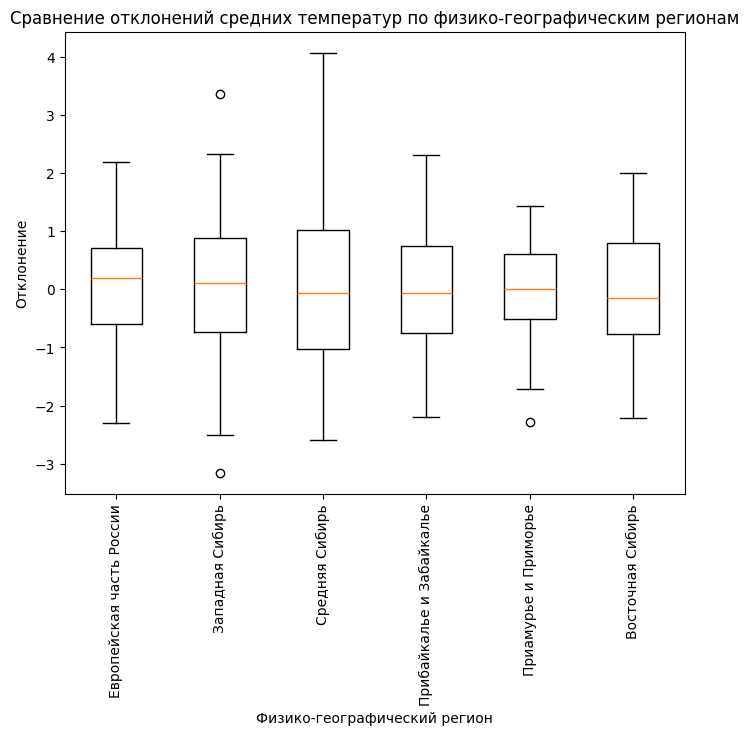

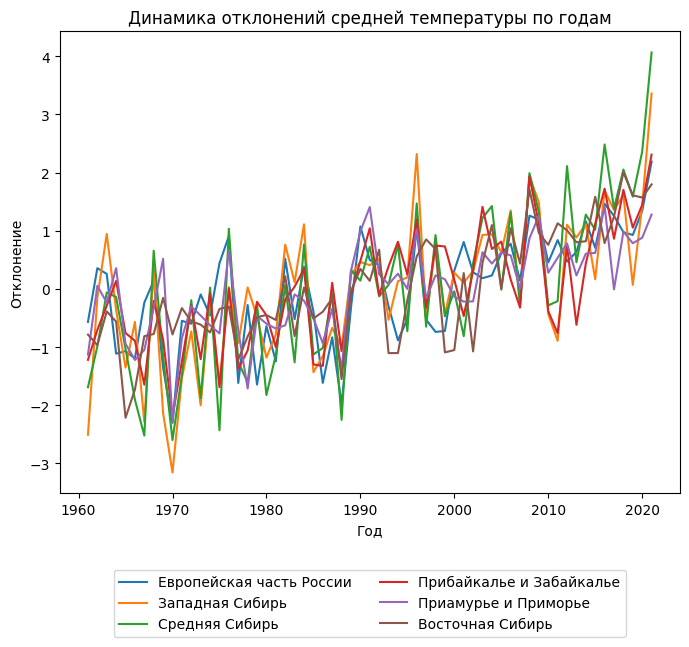

In [147]:
df_European = mainDataFrame[mainDataFrame['Индекс ВМО'].isin(zones_FGR_df[0]['Индекс ВМО'])]
df_West_Siberia = mainDataFrame[mainDataFrame['Индекс ВМО'].isin(zones_FGR_df[1]['Индекс ВМО'])]
df_Middle_Siberia = mainDataFrame[mainDataFrame['Индекс ВМО'].isin(zones_FGR_df[2]['Индекс ВМО'])]
df_Baikal = mainDataFrame[mainDataFrame['Индекс ВМО'].isin(zones_FGR_df[3]['Индекс ВМО'])]
df_Seaside = mainDataFrame[mainDataFrame['Индекс ВМО'].isin(zones_FGR_df[4]['Индекс ВМО'])]
df_East_Siberia = mainDataFrame[mainDataFrame['Индекс ВМО'].isin(zones_FGR_df[5]['Индекс ВМО'])]

df_European_year = df_European['Средняя температура воздуха'].resample("YE").mean()
df_European_year_mean = df_European_year.mean()
res = df_European_year - df_European_year_mean
group_1 = res.values

df_West_Siberia_year = df_West_Siberia['Средняя температура воздуха'].resample("YE").mean()
df_West_Siberia_year_mean = df_West_Siberia_year.mean()
res = df_West_Siberia_year - df_West_Siberia_year_mean
group_2 = res.values

df_Middle_Siberia_year = df_Middle_Siberia['Средняя температура воздуха'].resample("YE").mean()
df_Middle_Siberia_year_mean = df_Middle_Siberia_year.mean()
res = df_Middle_Siberia_year - df_Middle_Siberia_year_mean
group_3 = res.values

df_Baikal_year = df_Baikal['Средняя температура воздуха'].resample("YE").mean()
df_Baikal_year_mean = df_Baikal_year.mean()
res = df_Baikal_year - df_Baikal_year_mean
group_4 = res.values

df_Seaside_year = df_Seaside['Средняя температура воздуха'].resample("YE").mean()
df_Seaside_year_mean = df_Seaside_year.mean()
res = df_Seaside_year - df_Seaside_year_mean
group_5 = res.values

df_East_Siberia_year = df_East_Siberia['Средняя температура воздуха'].resample("YE").mean()
df_East_Siberia_year_mean = df_East_Siberia_year.mean()
res = df_East_Siberia_year - df_East_Siberia_year_mean
group_6 = res.values

groups = {'group_1': group_1, 'group_2': group_2, 'group_3': group_3, 'group_4': group_4, 'group_5': group_5, 'group_6': group_6 }
checkNormality(groups)
checkHomoscedasticity(groups)

res = oneFactorANOVA(groups)
if res[-1] < 0.05:
    print('Отвергаем гипотезу Н0, присутствует значимое различие между группами (p_value = {})'.format(res[-1]))
else:
    print('Принимаем гипотезу Н0, отсутсвует значимое различие между группами (p_value = {})'.format(res[-1]))

plt.figure(figsize=(8, 6))
plt.boxplot([group_1, group_2, group_3, group_4, group_5, group_6], labels=['Европейская часть России', 'Западная Сибирь', 'Средняя Сибирь', 'Прибайкалье и Забайкалье', 'Приамурье и Приморье', 'Восточная Сибирь'])
plt.title('Сравнение отклонений средних температур по физико-географическим регионам')
plt.ylabel('Отклонение')
plt.xlabel('Физико-географический регион')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(df_European_year.index, group_1, label='Европейская часть России')
plt.plot(df_West_Siberia_year.index, group_2, label='Западная Сибирь')
plt.plot(df_Middle_Siberia_year.index, group_3, label='Средняя Сибирь')
plt.plot(df_Baikal_year.index, group_4, label='Прибайкалье и Забайкалье')
plt.plot(df_Seaside_year.index, group_5, label='Приамурье и Приморье')
plt.plot(df_East_Siberia_year.index, group_6, label='Восточная Сибирь')
plt.title('Динамика отклонений средней температуры по годам')
plt.xlabel('Год')
plt.ylabel('Отклонение')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.show()


## (Х) ONE-FACTOR ANOVA (КЛИМАТИЧЕСКИЕ ЗОНЫ)

### Летние месяцы (дисперсии неоднородны)

Образец из группы group_1 выглядит как нормальное распределение (не отвергаем H0) (p = 0.09091464791297296)
Образец из группы group_2 выглядит как нормальное распределение (не отвергаем H0) (p = 0.05433791009008658)
Образец из группы group_3 выглядит как нормальное распределение (не отвергаем H0) (p = 0.10027197909195094)
Образец из группы group_4 выглядит как нормальное распределение (не отвергаем H0) (p = 0.1970546660535646)
Образец из группы group_5 выглядит как нормальное распределение (не отвергаем H0) (p = 0.14792090895928167)
Дисперсии однородны (гомоскедастичность не отвергается) (1.6574888671722878 < 2.4092566006847984)
Отвергаем гипотезу Н0, присутствует значимое различие между группами (p_value = 1.1102230246251565e-16)


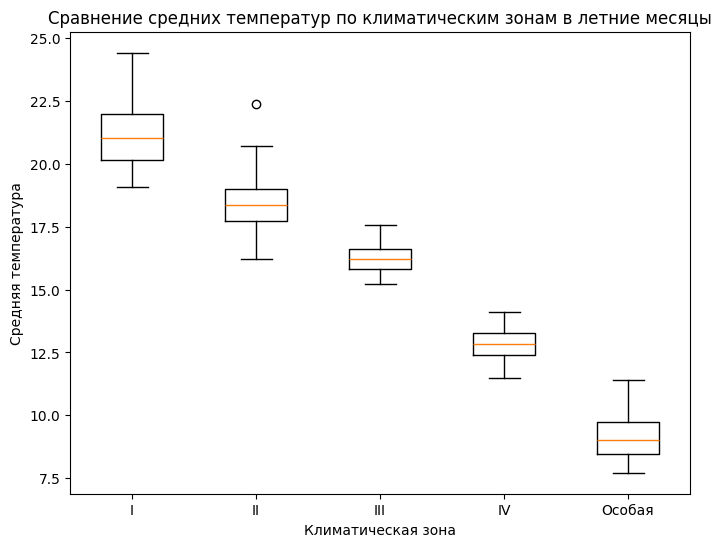

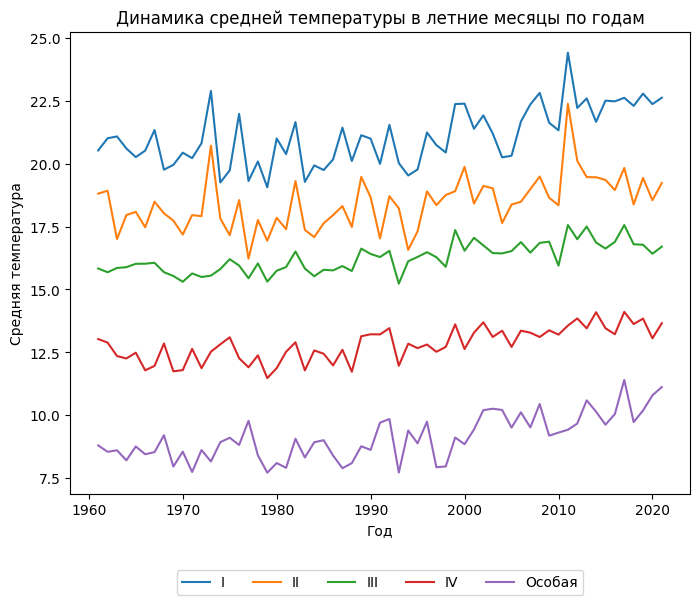

In [73]:
df_First = mainDataFrame[mainDataFrame['Индекс ВМО'].isin(zones_Climate_df[0]['Индекс ВМО'])]
df_Second = mainDataFrame[mainDataFrame['Индекс ВМО'].isin(zones_Climate_df[1]['Индекс ВМО'])]
df_Third = mainDataFrame[mainDataFrame['Индекс ВМО'].isin(zones_Climate_df[2]['Индекс ВМО'])]
df_Fourth = mainDataFrame[mainDataFrame['Индекс ВМО'].isin(zones_Climate_df[3]['Индекс ВМО'])]
df_Special = mainDataFrame[mainDataFrame['Индекс ВМО'].isin(zones_Climate_df[4]['Индекс ВМО'])]

df_First_summer = df_First['Средняя температура воздуха'].groupby(df_First.index.month)
df_First_summer = pd.concat([df_First_summer.get_group(6), df_First_summer.get_group(7), df_First_summer.get_group(8)])
df_First_summer = df_First_summer.resample("YE").mean()
group_1 = df_First_summer.values

df_Second_summer = df_Second['Средняя температура воздуха'].groupby(df_Second.index.month)
df_Second_summer = pd.concat([df_Second_summer.get_group(6), df_Second_summer.get_group(7), df_Second_summer.get_group(8)])
df_Second_summer = df_Second_summer.resample("YE").mean()
group_2 = df_Second_summer.values

df_Third_summer = df_Third['Средняя температура воздуха'].groupby(df_Third.index.month)
df_Third_summer = pd.concat([df_Third_summer.get_group(6), df_Third_summer.get_group(7), df_Third_summer.get_group(8)])
df_Third_summer = df_Third_summer.resample("YE").mean()
group_3 = df_Third_summer.values

df_Fourth_summer = df_Fourth['Средняя температура воздуха'].groupby(df_Fourth.index.month)
df_Fourth_summer = pd.concat([df_Fourth_summer.get_group(6), df_Fourth_summer.get_group(7), df_Fourth_summer.get_group(8)])
df_Fourth_summer = df_Fourth_summer.resample("YE").mean()
group_4 = df_Fourth_summer.values

df_Special_summer = df_Special['Средняя температура воздуха'].groupby(df_Special.index.month)
df_Special_summer = pd.concat([df_Special_summer.get_group(6), df_Special_summer.get_group(7), df_Special_summer.get_group(8)])
df_Special_summer = df_Special_summer.resample("YE").mean()
group_5 = df_Special_summer.values

groups = {'group_1': group_1, 'group_2': group_2, 'group_3': group_3, 'group_4': group_4, 'group_5': group_5}
checkNormality(groups)
checkHomoscedasticity(groups)

res = oneFactorANOVA(groups)
if res[-1] < 0.05:
    print('Отвергаем гипотезу Н0, присутствует значимое различие между группами (p_value = {})'.format(res[-1]))
else:
    print('Принимаем гипотезу Н0, отсутсвует значимое различие между группами (p_value = {})'.format(res[-1]))

plt.figure(figsize=(8, 6))
plt.boxplot([group_1, group_2, group_3, group_4, group_5], labels=['I', 'II', 'III', 'IV', 'Особая'])
plt.title('Сравнение средних температур по климатическим зонам в летние месяцы')
plt.ylabel('Средняя температура')
plt.xlabel('Климатическая зона')
# plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(df_First_summer.index, group_1, label='I')
plt.plot(df_Second_summer.index, group_2, label='II')
plt.plot(df_Third_summer.index, group_3, label='III')
plt.plot(df_Fourth_summer.index, group_4, label='IV')
plt.plot(df_Special_summer.index, group_5, label='Особая')
plt.title('Динамика средней температуры в летние месяцы по годам')
plt.xlabel('Год')
plt.ylabel('Средняя температура')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()

### Зимние месяцы (5 группа не распределена нормально)

Образец из группы group_1 выглядит как нормальное распределение (не отвергаем H0) (p = 0.28986352912763125)
Образец из группы group_2 выглядит как нормальное распределение (не отвергаем H0) (p = 0.32888424265721894)
Образец из группы group_3 выглядит как нормальное распределение (не отвергаем H0) (p = 0.28201712673315293)
Образец из группы group_4 выглядит как нормальное распределение (не отвергаем H0) (p = 0.54132661467158)
Образец из группы group_5 НЕ выглядит как нормальное распределение (отвергаем H0) (p = 0.02265141422166323)
Дисперсии однородны (гомоскедастичность не отвергается) (1.236209161519899 < 2.4092566006847984)
Отвергаем гипотезу Н0, присутствует значимое различие между группами (p_value = 1.1102230246251565e-16)


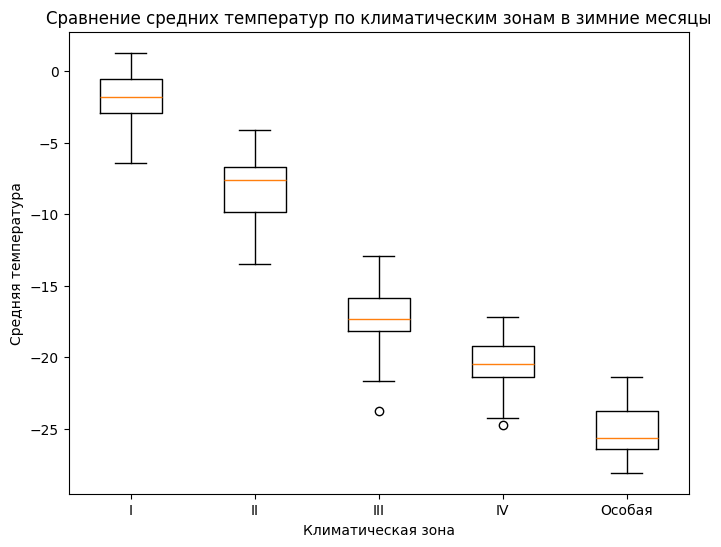

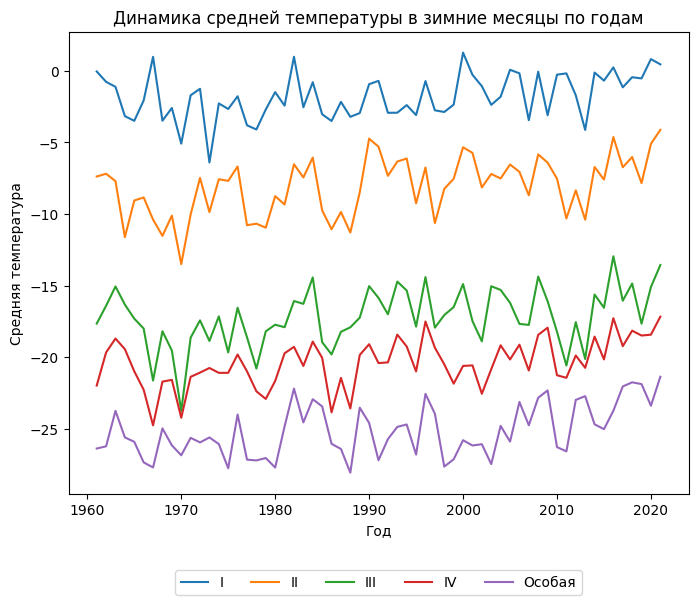

In [74]:
df_First = mainDataFrame[mainDataFrame['Индекс ВМО'].isin(zones_Climate_df[0]['Индекс ВМО'])]
df_Second = mainDataFrame[mainDataFrame['Индекс ВМО'].isin(zones_Climate_df[1]['Индекс ВМО'])]
df_Third = mainDataFrame[mainDataFrame['Индекс ВМО'].isin(zones_Climate_df[2]['Индекс ВМО'])]
df_Fourth = mainDataFrame[mainDataFrame['Индекс ВМО'].isin(zones_Climate_df[3]['Индекс ВМО'])]
df_Special = mainDataFrame[mainDataFrame['Индекс ВМО'].isin(zones_Climate_df[4]['Индекс ВМО'])]

df_First_winter = df_First['Средняя температура воздуха'].groupby(df_First.index.month)
df_First_winter = pd.concat([df_First_winter.get_group(12), df_First_winter.get_group(1), df_First_winter.get_group(2)])
df_First_winter = df_First_winter.resample("YE").mean()
group_1 = df_First_winter.values

df_Second_winter = df_Second['Средняя температура воздуха'].groupby(df_Second.index.month)
df_Second_winter = pd.concat([df_Second_winter.get_group(12), df_Second_winter.get_group(1), df_Second_winter.get_group(2)])
df_Second_winter = df_Second_winter.resample("YE").mean()
group_2 = df_Second_winter.values

df_Third_winter = df_Third['Средняя температура воздуха'].groupby(df_Third.index.month)
df_Third_winter = pd.concat([df_Third_winter.get_group(12), df_Third_winter.get_group(1), df_Third_winter.get_group(2)])
df_Third_winter = df_Third_winter.resample("YE").mean()
group_3 = df_Third_winter.values

df_Fourth_winter = df_Fourth['Средняя температура воздуха'].groupby(df_Fourth.index.month)
df_Fourth_winter = pd.concat([df_Fourth_winter.get_group(12), df_Fourth_winter.get_group(1), df_Fourth_winter.get_group(2)])
df_Fourth_winter = df_Fourth_winter.resample("YE").mean()
group_4 = df_Fourth_winter.values

df_Special_winter = df_Special['Средняя температура воздуха'].groupby(df_Special.index.month)
df_Special_winter = pd.concat([df_Special_winter.get_group(12), df_Special_winter.get_group(1), df_Special_winter.get_group(2)])
df_Special_winter = df_Special_winter.resample("YE").mean()
group_5 = df_Special_winter.values

groups = {'group_1': group_1, 'group_2': group_2, 'group_3': group_3, 'group_4': group_4, 'group_5': group_5}
checkNormality(groups)
checkHomoscedasticity(groups)

res = oneFactorANOVA(groups)
if res[-1] < 0.05:
    print('Отвергаем гипотезу Н0, присутствует значимое различие между группами (p_value = {})'.format(res[-1]))
else:
    print('Принимаем гипотезу Н0, отсутсвует значимое различие между группами (p_value = {})'.format(res[-1]))

plt.figure(figsize=(8, 6))
plt.boxplot([group_1, group_2, group_3, group_4, group_5], labels=['I', 'II', 'III', 'IV', 'Особая'])
plt.title('Сравнение средних температур по климатическим зонам в зимние месяцы')
plt.ylabel('Средняя температура')
plt.xlabel('Климатическая зона')
# plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(df_First_winter.index, group_1, label='I')
plt.plot(df_Second_winter.index, group_2, label='II')
plt.plot(df_Third_winter.index, group_3, label='III')
plt.plot(df_Fourth_winter.index, group_4, label='IV')
plt.plot(df_Special_winter.index, group_5, label='Особая')
plt.title('Динамика средней температуры в зимние месяцы по годам')
plt.xlabel('Год')
plt.ylabel('Средняя температура')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()

### Среднегодовая

Образец из группы group_1 выглядит как нормальное распределение (не отвергаем H0) (p = 0.45676078759014016)
Образец из группы group_2 выглядит как нормальное распределение (не отвергаем H0) (p = 0.49712289466004933)
Образец из группы group_3 выглядит как нормальное распределение (не отвергаем H0) (p = 0.907988501713943)
Образец из группы group_4 выглядит как нормальное распределение (не отвергаем H0) (p = 0.5925588916075457)
Образец из группы group_5 НЕ выглядит как нормальное распределение (отвергаем H0) (p = 0.00806327808513655)
Дисперсии однородны (гомоскедастичность не отвергается) (1.6376481408047059 < 2.4092566006847984)
Отвергаем гипотезу Н0, присутствует значимое различие между группами (p_value = 1.1102230246251565e-16)


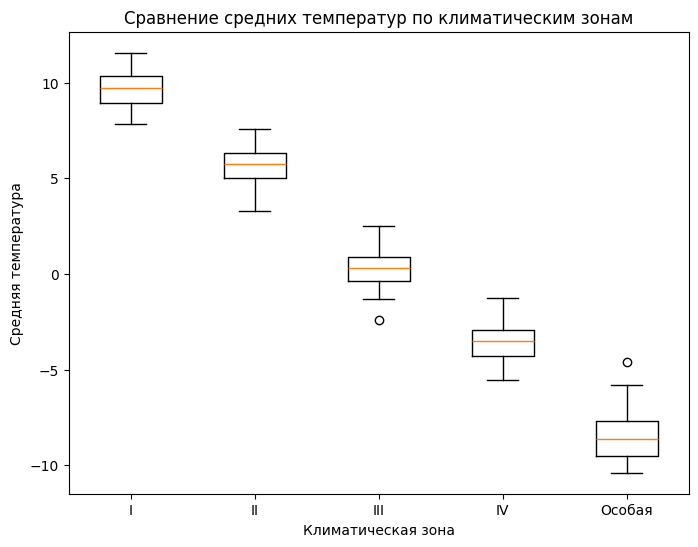

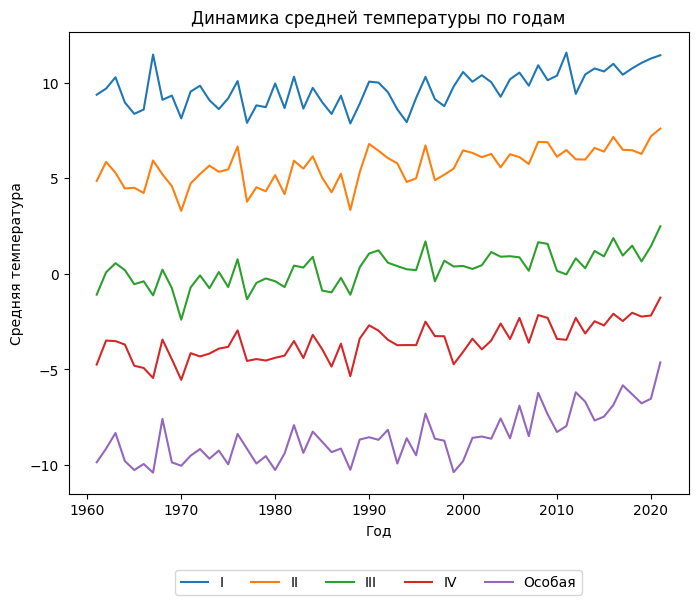

In [76]:
df_First = mainDataFrame[mainDataFrame['Индекс ВМО'].isin(zones_Climate_df[0]['Индекс ВМО'])]
df_Second = mainDataFrame[mainDataFrame['Индекс ВМО'].isin(zones_Climate_df[1]['Индекс ВМО'])]
df_Third = mainDataFrame[mainDataFrame['Индекс ВМО'].isin(zones_Climate_df[2]['Индекс ВМО'])]
df_Fourth = mainDataFrame[mainDataFrame['Индекс ВМО'].isin(zones_Climate_df[3]['Индекс ВМО'])]
df_Special = mainDataFrame[mainDataFrame['Индекс ВМО'].isin(zones_Climate_df[4]['Индекс ВМО'])]

df_First_year = df_First['Средняя температура воздуха'].resample("YE").mean()
group_1 = df_First_year.values

df_Second_year = df_Second['Средняя температура воздуха'].resample("YE").mean()
group_2 = df_Second_year.values

df_Third_year = df_Third['Средняя температура воздуха'].resample("YE").mean()
group_3 = df_Third_year.values

df_Fourth_year = df_Fourth['Средняя температура воздуха'].resample("YE").mean()
group_4 = df_Fourth_year.values

df_Special_year = df_Special['Средняя температура воздуха'].resample("YE").mean()
group_5 = df_Special_year.values

groups = {'group_1': group_1, 'group_2': group_2, 'group_3': group_3, 'group_4': group_4, 'group_5': group_5}
checkNormality(groups)
checkHomoscedasticity(groups)

res = oneFactorANOVA(groups)
if res[-1] < 0.05:
    print('Отвергаем гипотезу Н0, присутствует значимое различие между группами (p_value = {})'.format(res[-1]))
else:
    print('Принимаем гипотезу Н0, отсутсвует значимое различие между группами (p_value = {})'.format(res[-1]))

plt.figure(figsize=(8, 6))
plt.boxplot([group_1, group_2, group_3, group_4, group_5], labels=['I', 'II', 'III', 'IV', 'Особая'])
plt.title('Сравнение средних температур по климатическим зонам')
plt.ylabel('Средняя температура')
plt.xlabel('Климатическая зона')
# plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(df_First_year.index, group_1, label='I')
plt.plot(df_Second_year.index, group_2, label='II')
plt.plot(df_Third_year.index, group_3, label='III')
plt.plot(df_Fourth_year.index, group_4, label='IV')
plt.plot(df_Special_year.index, group_5, label='Особая')
plt.title('Динамика средней температуры по годам')
plt.xlabel('Год')
plt.ylabel('Средняя температура')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()

## !!! ГРАФИКИ СРЕДНЕСУТОЧНЫХ ТЕМПЕРАТУР

In [ ]:
dataFrameZone6_1961_1990 = dataFrameZone6['1961-01-01':'1990-12-31']
dataFrameZone6_1991_2020 = dataFrameZone6['1991-01-01':'2020-12-31']

dataFrameZone6_1961_1990 = dataFrameZone6_1961_1990.groupby(dataFrameZone6_1961_1990.index.month)
dataFrameZone6_1961_1990_july = dataFrameZone6_1961_1990.get_group(2)
dataFrameZone6_1961_1990_july = dataFrameZone6_1961_1990_july['Средняя температура воздуха'].groupby(dataFrameZone6_1961_1990_july['Средняя температура воздуха'].index.day)
data1 = dataFrameZone6_1961_1990_july.mean()

dataFrameZone6_1991_2020 = dataFrameZone6_1991_2020.groupby(dataFrameZone6_1991_2020.index.month)
dataFrameZone6_1991_2020_july = dataFrameZone6_1991_2020.get_group(2)
dataFrameZone6_1991_2020_july = dataFrameZone6_1991_2020_july['Средняя температура воздуха'].groupby(dataFrameZone6_1991_2020_july['Средняя температура воздуха'].index.day)
data2 = dataFrameZone6_1991_2020_july.mean()

plt.figure(figsize=(10, 6))
plt.plot(data1.index, data1, color='b', linestyle='-', marker='o', label='февраль 1961-1990')
plt.plot(data2.index, data2, color='r', linestyle='-', marker='o', label='февраль 1991-2020')
plt.xlabel('Дни', fontsize=12)
plt.ylabel('Средняя температура воздуха', fontsize=12)
plt.title('Тренд средних температур в феврале 1961-2020 в Зоне №6', fontsize=14) 
plt.grid(True)
plt.legend()
plt.show()


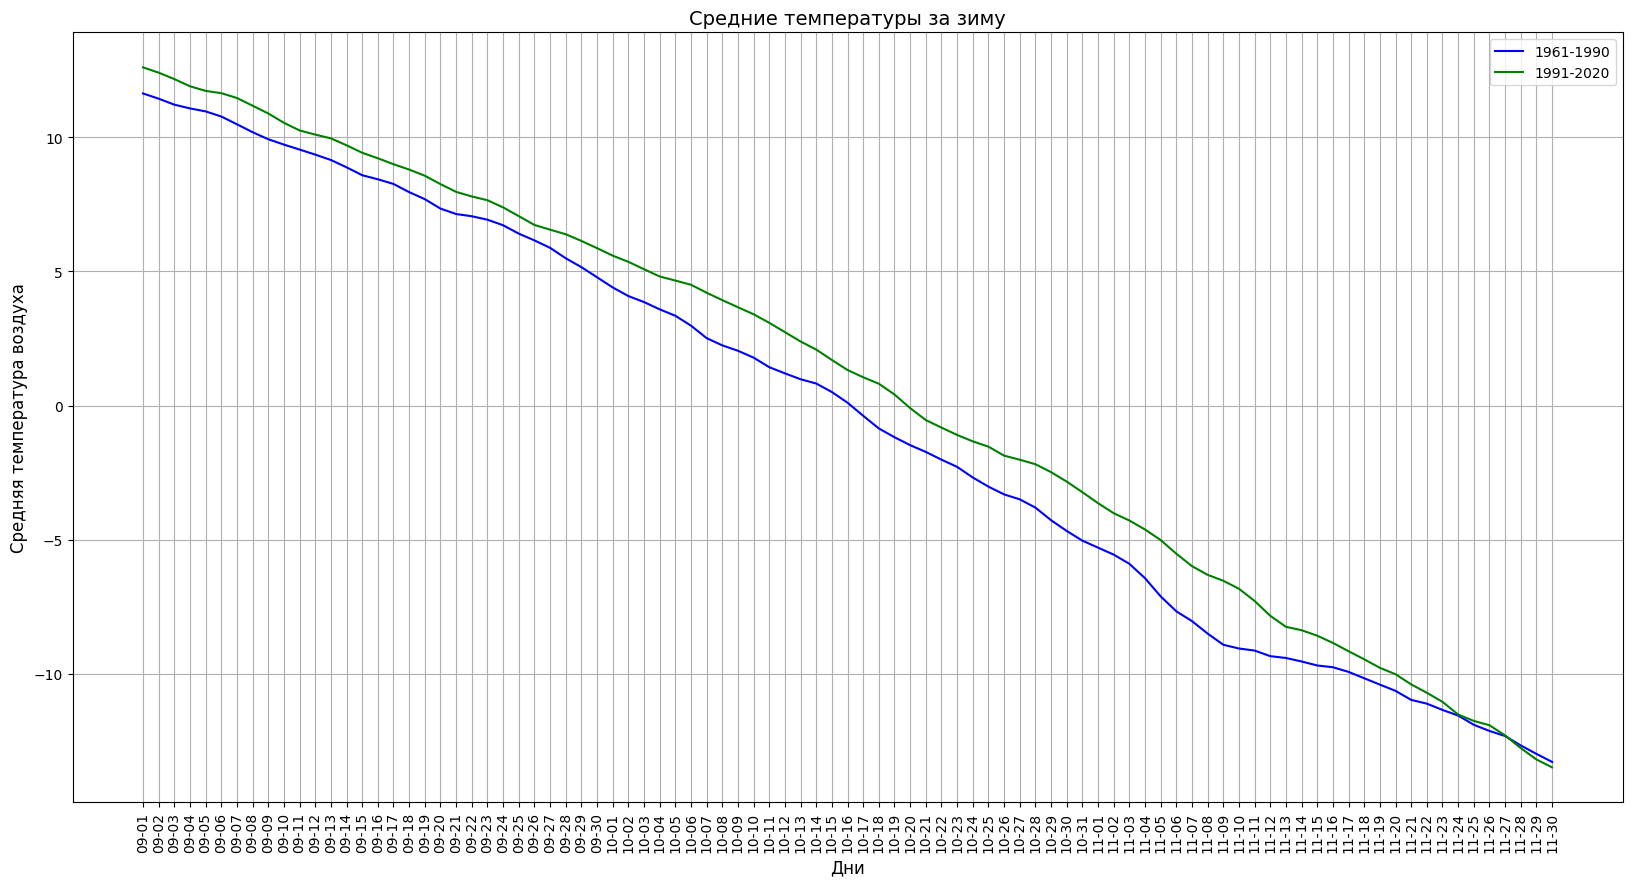

Максимальная разница: 2.3843279047076305


In [63]:
df_1961_1990 = mainDataFrame['1961-01-01':'1990-12-31']
df_1991_2020 = mainDataFrame['1991-01-01':'2020-12-31']

df_1961_1990 = df_1961_1990.groupby(df_1961_1990.index.month)
df_1961_1990_summer = pd.concat([df_1961_1990.get_group(9), df_1961_1990.get_group(10), df_1961_1990.get_group(11)])
df_1961_1990_summer = df_1961_1990_summer['Средняя температура воздуха'].groupby(df_1961_1990_summer['Средняя температура воздуха'].index.strftime('%m-%d'))
data1 = df_1961_1990_summer.mean()

df_1991_2020 = df_1991_2020.groupby(df_1991_2020.index.month)
df_1991_2020_summer = pd.concat([df_1991_2020.get_group(9), df_1991_2020.get_group(10), df_1991_2020.get_group(11)])
df_1991_2020_summer = df_1991_2020_summer['Средняя температура воздуха'].groupby(df_1991_2020_summer['Средняя температура воздуха'].index.strftime('%m-%d'))
data2 = df_1991_2020_summer.mean()

plt.figure(figsize=(20, 10))
plt.xlabel('Дни', fontsize=12)
plt.ylabel('Средняя температура воздуха', fontsize=12)
plt.title('Средние температуры за зиму', fontsize=14) 
plt.grid(True)
sorted_days = list(data1.index[data1.index.str.startswith('12')]) + list(data1.index[~data1.index.str.startswith('12')])
data1 = data1.reindex(sorted_days)
data2 = data2.reindex(sorted_days)
plt.plot(data1.index, data1, color='b', linestyle='-', label='1961-1990')
plt.plot(data2.index, data2, color='g', linestyle='-', label='1991-2020')
plt.xticks(data1.index[::1], rotation=90)
plt.legend()
plt.show()


differences = np.abs(data1 - data2)
max_difference = np.max(differences)
print("Максимальная разница:", max_difference)